In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2603.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2603.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,32.259,32.685,31.939,32.152,16.318,16352913.000,2603.TW,28.745,32.685,...,62.667,71.029,56.480,0.487,0.309,31.776,29.970,28.164,1,0
1,2000-02-01,32.472,32.472,31.513,31.726,16.102,10636015.000,2603.TW,28.745,32.685,...,62.667,72.578,61.846,0.561,0.360,31.987,30.119,28.250,0,1
2,2000-02-02,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,28.958,32.685,...,57.576,73.147,65.613,0.613,0.410,32.107,30.284,28.460,0,1
3,2000-02-03,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.384,32.685,...,63.333,72.421,67.882,0.646,0.458,32.263,30.411,28.560,0,1
4,2000-02-04,31.726,31.726,31.726,31.726,16.102,0.000,2603.TW,29.491,32.685,...,65.517,71.614,69.126,0.665,0.499,32.348,30.438,28.528,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2023-02-23,153.500,158.500,153.500,158.000,158.000,34299954.000,2603.TW,142.500,158.500,...,59.459,74.173,55.450,-0.771,-1.805,158.279,150.800,143.321,1,0
5757,2023-02-24,158.500,159.500,155.500,157.000,157.000,32154792.000,2603.TW,145.000,159.500,...,57.333,77.035,62.645,-0.258,-1.495,158.953,151.025,143.097,1,0
5758,2023-03-01,157.500,158.000,154.000,156.000,156.000,21240175.000,2603.TW,145.000,159.500,...,58.108,76.644,67.311,0.068,-1.183,159.512,151.300,143.088,0,1
5759,2023-03-02,158.000,161.000,157.500,160.500,160.500,33776976.000,2603.TW,145.000,161.000,...,67.532,83.388,72.670,0.680,-0.810,160.865,151.725,142.585,1,0


# 查找DF的標籤

In [7]:
dfStartDate_Train = df[(df['index']=='2020-01-03')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4994

In [8]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5726

In [9]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4994,2020-01-03,32.000,32.625,31.875,32.500,25.802,13275073.000,2603.TW,31.000,32.625,...,67.857,62.257,52.628,0.133,0.006,32.085,31.156,30.228,1,0
4995,2020-01-06,32.500,33.000,32.250,32.500,25.802,10429668.000,2603.TW,31.000,33.000,...,64.000,66.505,57.253,0.207,0.046,32.314,31.250,30.186,1,0
4996,2020-01-07,32.500,32.625,32.125,32.250,25.603,5552326.000,2603.TW,31.000,33.000,...,66.667,65.170,59.892,0.242,0.086,32.428,31.337,30.247,0,1
4997,2020-01-08,31.875,31.875,31.500,31.500,25.008,5703694.000,2603.TW,31.000,33.000,...,57.143,51.780,57.188,0.208,0.110,32.423,31.381,30.340,0,1
4998,2020-01-09,31.875,32.375,31.750,32.125,25.504,5810333.000,2603.TW,31.000,33.000,...,60.000,53.270,55.882,0.228,0.134,32.469,31.462,30.456,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,2022-12-26,168.500,168.500,162.500,162.500,162.500,23661784.000,2603.TW,151.000,172.000,...,62.366,67.278,64.430,3.172,2.330,170.040,159.075,148.110,0,1
5723,2022-12-27,164.000,167.000,162.000,162.500,162.500,19106328.000,2603.TW,152.500,172.000,...,59.302,61.946,63.602,3.004,2.465,170.187,159.150,148.113,0,1
5724,2022-12-28,162.000,164.000,159.000,159.000,159.000,20189077.000,2603.TW,154.000,172.000,...,54.839,50.557,59.253,2.559,2.483,169.844,158.950,148.056,0,1
5725,2022-12-29,159.000,161.000,157.500,160.000,160.000,17346004.000,2603.TW,157.500,172.000,...,55.319,39.452,52.653,2.261,2.439,169.667,158.850,148.033,0,1


In [10]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['K_Value', 'D_Value']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [13]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.
----------------------------------
| explained_variance | -4.52e-05 |
| fps                | 9         |
| nupdates           | 1         |
| policy_entropy     | 0.648     |
| total_timesteps    | 5         |
| value_loss         | 1.21e+06  |
----------------------------------
----------------------------------
| explained_variance | -0.000718 |
| fps                | 262       |
| nupdates           | 100       |
| policy_entropy     | 0.684     |
| total_timesteps    | 500       |
| value_loss         | 9.02e+04  |
----------------------------------
---------------------------------
| explained_variance | 9.21e-05 |
| fps                | 300      |
| nupdates           | 200      |
| policy_entropy     | 0.589    |
| total_timesteps    | 1000     |
| value_loss         | 1.34e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.88e-05 |
| fps                | 326       |
| nupdates           | 300  

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 356       |
| nupdates           | 3000      |
| policy_entropy     | 0.00661   |
| total_timesteps    | 15000     |
| value_loss         | 4.53e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 354       |
| nupdates           | 3100      |
| policy_entropy     | 0.00702   |
| total_timesteps    | 15500     |
| value_loss         | 1.01e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 351       |
| nupdates           | 3200      |
| policy_entropy     | 0.00698   |
| total_timesteps    | 16000     |
| value_loss         | 8.36e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 348       |
| nupdates           | 3300      |
| policy_entropy    

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 6000      |
| policy_entropy     | 0.00137   |
| total_timesteps    | 30000     |
| value_loss         | 1.21e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 6100     |
| policy_entropy     | 0.0014   |
| total_timesteps    | 30500    |
| value_loss         | 7.03e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 6200      |
| policy_entropy     | 0.00139   |
| total_timesteps    | 31000     |
| value_loss         | 5.08e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 6300     |
| policy_entropy     | 0.00142  

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 372       |
| nupdates           | 9000      |
| policy_entropy     | 0.000847  |
| total_timesteps    | 45000     |
| value_loss         | 1.95e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 372       |
| nupdates           | 9100      |
| policy_entropy     | 0.000844  |
| total_timesteps    | 45500     |
| value_loss         | 1.93e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 371      |
| nupdates           | 9200     |
| policy_entropy     | 0.000875 |
| total_timesteps    | 46000    |
| value_loss         | 2.37e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 371      |
| nupdates           | 9300     |
| policy_entropy     | 0.000846 

---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 12000    |
| policy_entropy     | 0.00113  |
| total_timesteps    | 60000    |
| value_loss         | 1.16e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 369       |
| nupdates           | 12100     |
| policy_entropy     | 0.001     |
| total_timesteps    | 60500     |
| value_loss         | 5.92e+06  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 370       |
| nupdates           | 12200     |
| policy_entropy     | 0.00101   |
| total_timesteps    | 61000     |
| value_loss         | 8.51e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 370      |
| nupdates           | 12300    |
| policy_entropy     | 0.00104  

---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 15000    |
| policy_entropy     | 0.000876 |
| total_timesteps    | 75000    |
| value_loss         | 2.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 374      |
| nupdates           | 15100    |
| policy_entropy     | 0.000885 |
| total_timesteps    | 75500    |
| value_loss         | 1.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 15200    |
| policy_entropy     | 0.000859 |
| total_timesteps    | 76000    |
| value_loss         | 8.16e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 374       |
| nupdates           | 15300     |
| policy_entropy     | 0.000865  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 378      |
| nupdates           | 18000    |
| policy_entropy     | 0.00108  |
| total_timesteps    | 90000    |
| value_loss         | 3.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 378      |
| nupdates           | 18100    |
| policy_entropy     | 0.00103  |
| total_timesteps    | 90500    |
| value_loss         | 1.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 378      |
| nupdates           | 18200    |
| policy_entropy     | 0.00075  |
| total_timesteps    | 91000    |
| value_loss         | 5.4e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 378      |
| nupdates           | 18300    |
| policy_entropy     | 0.00078  |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 381       |
| nupdates           | 21100     |
| policy_entropy     | 0.00089   |
| total_timesteps    | 105500    |
| value_loss         | 5.66e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 21200    |
| policy_entropy     | 0.000876 |
| total_timesteps    | 106000   |
| value_loss         | 1.44e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 381       |
| nupdates           | 21300     |
| policy_entropy     | 0.000888  |
| total_timesteps    | 106500    |
| value_loss         | 2.13e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 21400    |
| policy_entropy     | 0.000889 

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 384      |
| nupdates           | 24100    |
| policy_entropy     | 0.000689 |
| total_timesteps    | 120500   |
| value_loss         | 4.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 384      |
| nupdates           | 24200    |
| policy_entropy     | 0.000695 |
| total_timesteps    | 121000   |
| value_loss         | 1.65e+08 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 384      |
| nupdates           | 24300    |
| policy_entropy     | 0.000685 |
| total_timesteps    | 121500   |
| value_loss         | 6.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 384      |
| nupdates           | 24400    |
| policy_entropy     | 0.000718 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 386       |
| nupdates           | 27100     |
| policy_entropy     | 0.000788  |
| total_timesteps    | 135500    |
| value_loss         | 2.81e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 386      |
| nupdates           | 27200    |
| policy_entropy     | 0.000779 |
| total_timesteps    | 136000   |
| value_loss         | 4.71e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 386      |
| nupdates           | 27300    |
| policy_entropy     | 0.000787 |
| total_timesteps    | 136500   |
| value_loss         | 9.63e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 386       |
| nupdates           | 27400     |
| policy_entropy     | 0.000785  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 388       |
| nupdates           | 30100     |
| policy_entropy     | 0.000547  |
| total_timesteps    | 150500    |
| value_loss         | 6.66e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 388      |
| nupdates           | 30200    |
| policy_entropy     | 0.000521 |
| total_timesteps    | 151000   |
| value_loss         | 1.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 388      |
| nupdates           | 30300    |
| policy_entropy     | 0.000526 |
| total_timesteps    | 151500   |
| value_loss         | 7.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 388      |
| nupdates           | 30400    |
| policy_entropy     | 0.000525 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 390      |
| nupdates           | 33100    |
| policy_entropy     | 0.00058  |
| total_timesteps    | 165500   |
| value_loss         | 1.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 390      |
| nupdates           | 33200    |
| policy_entropy     | 0.000564 |
| total_timesteps    | 166000   |
| value_loss         | 2.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 390      |
| nupdates           | 33300    |
| policy_entropy     | 0.000706 |
| total_timesteps    | 166500   |
| value_loss         | 4.08e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 390       |
| nupdates           | 33400     |
| policy_entropy     | 0.000578  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 392      |
| nupdates           | 36100    |
| policy_entropy     | 0.000629 |
| total_timesteps    | 180500   |
| value_loss         | 1.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 392      |
| nupdates           | 36200    |
| policy_entropy     | 0.000642 |
| total_timesteps    | 181000   |
| value_loss         | 1.18e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 392       |
| nupdates           | 36300     |
| policy_entropy     | 0.000692  |
| total_timesteps    | 181500    |
| value_loss         | 9.25e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 392      |
| nupdates           | 36400    |
| policy_entropy     | 0.000637 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 393      |
| nupdates           | 39100    |
| policy_entropy     | 0.000493 |
| total_timesteps    | 195500   |
| value_loss         | 5.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 393      |
| nupdates           | 39200    |
| policy_entropy     | 0.000492 |
| total_timesteps    | 196000   |
| value_loss         | 1.03e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 394       |
| nupdates           | 39300     |
| policy_entropy     | 0.000495  |
| total_timesteps    | 196500    |
| value_loss         | 1.09e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 394       |
| nupdates           | 39400     |
| policy_entropy     | 0.000496  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 395      |
| nupdates           | 42100    |
| policy_entropy     | 0.000545 |
| total_timesteps    | 210500   |
| value_loss         | 2.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 395      |
| nupdates           | 42200    |
| policy_entropy     | 0.000561 |
| total_timesteps    | 211000   |
| value_loss         | 1.1e+05  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 395       |
| nupdates           | 42300     |
| policy_entropy     | 0.000545  |
| total_timesteps    | 211500    |
| value_loss         | 8.97e+04  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 395      |
| nupdates           | 42400    |
| policy_entropy     | 0.000552 |
| tota

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 396      |
| nupdates           | 45100    |
| policy_entropy     | 0.000814 |
| total_timesteps    | 225500   |
| value_loss         | 2.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 396      |
| nupdates           | 45200    |
| policy_entropy     | 0.000876 |
| total_timesteps    | 226000   |
| value_loss         | 1.58e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 396      |
| nupdates           | 45300    |
| policy_entropy     | 0.000817 |
| total_timesteps    | 226500   |
| value_loss         | 6.63e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 396       |
| nupdates           | 45400     |
| policy_entropy     | 0.000815  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 397      |
| nupdates           | 48100    |
| policy_entropy     | 0.000953 |
| total_timesteps    | 240500   |
| value_loss         | 1.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 397      |
| nupdates           | 48200    |
| policy_entropy     | 0.000959 |
| total_timesteps    | 241000   |
| value_loss         | 5.05e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 397       |
| nupdates           | 48300     |
| policy_entropy     | 0.000976  |
| total_timesteps    | 241500    |
| value_loss         | 3.44e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 48400    |
| policy_entropy     | 0.000975 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 51100     |
| policy_entropy     | 0.00199   |
| total_timesteps    | 255500    |
| value_loss         | 8.8e+07   |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 398      |
| nupdates           | 51200    |
| policy_entropy     | 0.00204  |
| total_timesteps    | 256000   |
| value_loss         | 1.33e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 51300     |
| policy_entropy     | 0.00199   |
| total_timesteps    | 256500    |
| value_loss         | 2.25e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 398      |
| nupdates           | 51400    |
| policy_entropy     | 0.00205  

---------------------------------
| explained_variance | 0        |
| fps                | 399      |
| nupdates           | 54100    |
| policy_entropy     | 0.00195  |
| total_timesteps    | 270500   |
| value_loss         | 9.33e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 399      |
| nupdates           | 54200    |
| policy_entropy     | 0.00196  |
| total_timesteps    | 271000   |
| value_loss         | 1.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 399      |
| nupdates           | 54300    |
| policy_entropy     | 0.00198  |
| total_timesteps    | 271500   |
| value_loss         | 6.72e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 399       |
| nupdates           | 54400     |
| policy_entropy     | 0.00197   |
| total_t

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 400       |
| nupdates           | 57100     |
| policy_entropy     | 0.00225   |
| total_timesteps    | 285500    |
| value_loss         | 4.63e+04  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 400      |
| nupdates           | 57200    |
| policy_entropy     | 0.00238  |
| total_timesteps    | 286000   |
| value_loss         | 4.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 400      |
| nupdates           | 57300    |
| policy_entropy     | 0.00348  |
| total_timesteps    | 286500   |
| value_loss         | 3.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 400      |
| nupdates           | 57400    |
| policy_entropy     | 0.00338  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 400       |
| nupdates           | 60100     |
| policy_entropy     | 0.00221   |
| total_timesteps    | 300500    |
| value_loss         | 1.76e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 400      |
| nupdates           | 60200    |
| policy_entropy     | 0.00222  |
| total_timesteps    | 301000   |
| value_loss         | 2.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 400      |
| nupdates           | 60300    |
| policy_entropy     | 0.0023   |
| total_timesteps    | 301500   |
| value_loss         | 2.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 400      |
| nupdates           | 60400    |
| policy_entropy     | 0.00236  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 63100    |
| policy_entropy     | 0.00253  |
| total_timesteps    | 315500   |
| value_loss         | 8e+04    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 63200    |
| policy_entropy     | 0.00251  |
| total_timesteps    | 316000   |
| value_loss         | 2.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 401       |
| nupdates           | 63300     |
| policy_entropy     | 0.00261   |
| total_timesteps    | 316500    |
| value_loss         | 1.13e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 401       |
| nupdates           | 63400     |
| policy_entropy     | 0.00254   |
|

---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 401      |
| nupdates           | 66100    |
| policy_entropy     | 0.00261  |
| total_timesteps    | 330500   |
| value_loss         | 7.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 66200    |
| policy_entropy     | 0.00259  |
| total_timesteps    | 331000   |
| value_loss         | 1.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 66300    |
| policy_entropy     | 0.00271  |
| total_timesteps    | 331500   |
| value_loss         | 7.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 401      |
| nupdates           | 66400    |
| policy_entropy     | 0.00264  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 402       |
| nupdates           | 69100     |
| policy_entropy     | 0.00293   |
| total_timesteps    | 345500    |
| value_loss         | 2.56e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 402       |
| nupdates           | 69200     |
| policy_entropy     | 0.00301   |
| total_timesteps    | 346000    |
| value_loss         | 1.93e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 402      |
| nupdates           | 69300    |
| policy_entropy     | 0.00311  |
| total_timesteps    | 346500   |
| value_loss         | 5.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 402      |
| nupdates           | 69400    |
| policy_entropy     | 0.00323  

---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 72100    |
| policy_entropy     | 0.00399  |
| total_timesteps    | 360500   |
| value_loss         | 2.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 72200    |
| policy_entropy     | 0.00393  |
| total_timesteps    | 361000   |
| value_loss         | 4.29e+07 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 402       |
| nupdates           | 72300     |
| policy_entropy     | 0.00406   |
| total_timesteps    | 361500    |
| value_loss         | 2.09e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 402       |
| nupdates           | 72400     |
| policy_entropy     | 0.00328   |
|

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 403      |
| nupdates           | 75100    |
| policy_entropy     | 0.00163  |
| total_timesteps    | 375500   |
| value_loss         | 2.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 75200    |
| policy_entropy     | 0.00167  |
| total_timesteps    | 376000   |
| value_loss         | 1.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 75300    |
| policy_entropy     | 0.00168  |
| total_timesteps    | 376500   |
| value_loss         | 4.35e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 403      |
| nupdates           | 75400    |
| policy_entropy     | 0.00169  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 78100    |
| policy_entropy     | 0.00287  |
| total_timesteps    | 390500   |
| value_loss         | 7.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 78200    |
| policy_entropy     | 0.00294  |
| total_timesteps    | 391000   |
| value_loss         | 2.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 78300    |
| policy_entropy     | 0.00301  |
| total_timesteps    | 391500   |
| value_loss         | 1.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 403      |
| nupdates           | 78400    |
| policy_entropy     | 0.00317  |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 403      |
| nupdates           | 81100    |
| policy_entropy     | 0.00523  |
| total_timesteps    | 405500   |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 403      |
| nupdates           | 81200    |
| policy_entropy     | 0.00518  |
| total_timesteps    | 406000   |
| value_loss         | 1.2e+08  |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 403      |
| nupdates           | 81300    |
| policy_entropy     | 0.00542  |
| total_timesteps    | 406500   |
| value_loss         | 2.75e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 403      |
| nupdates           | 81400    |
| policy_entropy     | 0.00574  |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 404      |
| nupdates           | 84100    |
| policy_entropy     | 0.00207  |
| total_timesteps    | 420500   |
| value_loss         | 2.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 404      |
| nupdates           | 84200    |
| policy_entropy     | 0.00211  |
| total_timesteps    | 421000   |
| value_loss         | 1.4e+05  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 404       |
| nupdates           | 84300     |
| policy_entropy     | 0.0021    |
| total_timesteps    | 421500    |
| value_loss         | 4.62e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 404       |
| nupdates           | 84400     |
| policy_entropy     | 0.00214   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 87100    |
| policy_entropy     | 0.00132  |
| total_timesteps    | 435500   |
| value_loss         | 1.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 404      |
| nupdates           | 87200    |
| policy_entropy     | 0.00134  |
| total_timesteps    | 436000   |
| value_loss         | 9.11e+03 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 404       |
| nupdates           | 87300     |
| policy_entropy     | 0.00136   |
| total_timesteps    | 436500    |
| value_loss         | 6.19e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 404       |
| nupdates           | 87400     |
| policy_entropy     | 0.00137   |
|

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 404       |
| nupdates           | 90100     |
| policy_entropy     | 0.000762  |
| total_timesteps    | 450500    |
| value_loss         | 2.48e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 90200    |
| policy_entropy     | 0.000766 |
| total_timesteps    | 451000   |
| value_loss         | 7.81e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 404       |
| nupdates           | 90300     |
| policy_entropy     | 0.000767  |
| total_timesteps    | 451500    |
| value_loss         | 2.97e+04  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 404       |
| nupdates           | 90400     |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 405      |
| nupdates           | 93100    |
| policy_entropy     | 0.000984 |
| total_timesteps    | 465500   |
| value_loss         | 1.29e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 405      |
| nupdates           | 93200    |
| policy_entropy     | 0.000982 |
| total_timesteps    | 466000   |
| value_loss         | 7.09e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 405       |
| nupdates           | 93300     |
| policy_entropy     | 0.000982  |
| total_timesteps    | 466500    |
| value_loss         | 4.15e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 405       |
| nupdates           | 93400     |
| policy_entropy     | 0.000998  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 96100    |
| policy_entropy     | 0.000849 |
| total_timesteps    | 480500   |
| value_loss         | 1.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 96200    |
| policy_entropy     | 0.000855 |
| total_timesteps    | 481000   |
| value_loss         | 1.27e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 405       |
| nupdates           | 96300     |
| policy_entropy     | 0.000866  |
| total_timesteps    | 481500    |
| value_loss         | 3.76e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 405       |
| nupdates           | 96400     |
| policy_entropy     | 0.000875  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 99100    |
| policy_entropy     | 0.000623 |
| total_timesteps    | 495500   |
| value_loss         | 6.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 99200    |
| policy_entropy     | 0.000633 |
| total_timesteps    | 496000   |
| value_loss         | 1.31e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 405       |
| nupdates           | 99300     |
| policy_entropy     | 0.000623  |
| total_timesteps    | 496500    |
| value_loss         | 1.49e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 405       |
| nupdates           | 99400     |
| policy_entropy     | 0.000631  |
|

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 405      |
| nupdates           | 102100   |
| policy_entropy     | 0.000482 |
| total_timesteps    | 510500   |
| value_loss         | 2.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 102200   |
| policy_entropy     | 0.000488 |
| total_timesteps    | 511000   |
| value_loss         | 8.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 102300   |
| policy_entropy     | 0.000484 |
| total_timesteps    | 511500   |
| value_loss         | 8.84e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 405      |
| nupdates           | 102400   |
| policy_entropy     | 0.000518 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 405       |
| nupdates           | 105100    |
| policy_entropy     | 0.000525  |
| total_timesteps    | 525500    |
| value_loss         | 4.76e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 105200   |
| policy_entropy     | 0.000529 |
| total_timesteps    | 526000   |
| value_loss         | 1.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 405      |
| nupdates           | 105300   |
| policy_entropy     | 0.000331 |
| total_timesteps    | 526500   |
| value_loss         | 6.83e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 405      |
| nupdates           | 105400   |
| policy_entropy     | 0.000326 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 405       |
| nupdates           | 108100    |
| policy_entropy     | 0.000342  |
| total_timesteps    | 540500    |
| value_loss         | 1.43e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 405       |
| nupdates           | 108200    |
| policy_entropy     | 0.000341  |
| total_timesteps    | 541000    |
| value_loss         | 2.35e+05  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 405       |
| nupdates           | 108300    |
| policy_entropy     | 0.000343  |
| total_timesteps    | 541500    |
| value_loss         | 2.51e+05  |
----------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 405      |
| nupdates           | 108400   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 404      |
| nupdates           | 111100   |
| policy_entropy     | 0.000134 |
| total_timesteps    | 555500   |
| value_loss         | 5.42e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 404       |
| nupdates           | 111200    |
| policy_entropy     | 0.000135  |
| total_timesteps    | 556000    |
| value_loss         | 9.04e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 404      |
| nupdates           | 111300   |
| policy_entropy     | 0.000135 |
| total_timesteps    | 556500   |
| value_loss         | 7.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 404      |
| nupdates           | 111400   |
| policy_entropy     | 0.000134 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 403       |
| nupdates           | 114100    |
| policy_entropy     | 0.000137  |
| total_timesteps    | 570500    |
| value_loss         | 3.31e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 403      |
| nupdates           | 114200   |
| policy_entropy     | 0.000137 |
| total_timesteps    | 571000   |
| value_loss         | 2.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 114300   |
| policy_entropy     | 0.000138 |
| total_timesteps    | 571500   |
| value_loss         | 1.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 114400   |
| policy_entropy     | 0.000138 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 117100   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 585500   |
| value_loss         | 2.17e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 403       |
| nupdates           | 117200    |
| policy_entropy     | 0.00014   |
| total_timesteps    | 586000    |
| value_loss         | 3.39e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 403      |
| nupdates           | 117300   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 586500   |
| value_loss         | 5.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 403      |
| nupdates           | 117400   |
| policy_entropy     | 0.00014  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 402       |
| nupdates           | 120100    |
| policy_entropy     | 0.000145  |
| total_timesteps    | 600500    |
| value_loss         | 7.34e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 402       |
| nupdates           | 120200    |
| policy_entropy     | 0.000143  |
| total_timesteps    | 601000    |
| value_loss         | 3.9e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 120300   |
| policy_entropy     | 0.000143 |
| total_timesteps    | 601500   |
| value_loss         | 4.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 402      |
| nupdates           | 120400   |
| policy_entropy     | 0.000144 

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 402       |
| nupdates           | 123100    |
| policy_entropy     | 0.000146  |
| total_timesteps    | 615500    |
| value_loss         | 3.57e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 402      |
| nupdates           | 123200   |
| policy_entropy     | 0.000147 |
| total_timesteps    | 616000   |
| value_loss         | 2.08e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 402       |
| nupdates           | 123300    |
| policy_entropy     | 0.000147  |
| total_timesteps    | 616500    |
| value_loss         | 1.02e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 402      |
| nupdates           | 123400   |
| policy_entropy     | 0.000147 

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 401      |
| nupdates           | 126100   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 630500   |
| value_loss         | 1.31e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 401       |
| nupdates           | 126200    |
| policy_entropy     | 0.00015   |
| total_timesteps    | 631000    |
| value_loss         | 2.32e+04  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 401       |
| nupdates           | 126300    |
| policy_entropy     | 0.000157  |
| total_timesteps    | 631500    |
| value_loss         | 7.34e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 126400   |
| policy_entropy     | 0.000151 

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 401       |
| nupdates           | 129100    |
| policy_entropy     | 0.000153  |
| total_timesteps    | 645500    |
| value_loss         | 1.06e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 129200   |
| policy_entropy     | 0.000153 |
| total_timesteps    | 646000   |
| value_loss         | 2.11e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 401       |
| nupdates           | 129300    |
| policy_entropy     | 0.000154  |
| total_timesteps    | 646500    |
| value_loss         | 1.11e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 129400   |
| policy_entropy     | 0.000154 

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 401       |
| nupdates           | 132100    |
| policy_entropy     | 0.000157  |
| total_timesteps    | 660500    |
| value_loss         | 8.19e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 401      |
| nupdates           | 132200   |
| policy_entropy     | 0.000157 |
| total_timesteps    | 661000   |
| value_loss         | 3.26e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 401       |
| nupdates           | 132300    |
| policy_entropy     | 0.000157  |
| total_timesteps    | 661500    |
| value_loss         | 9.09e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 401      |
| nupdates           | 132400   |
| policy_entropy     | 0.000159 

---------------------------------
| explained_variance | 0        |
| fps                | 400      |
| nupdates           | 135100   |
| policy_entropy     | 0.000161 |
| total_timesteps    | 675500   |
| value_loss         | 1.29e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 400       |
| nupdates           | 135200    |
| policy_entropy     | 0.000162  |
| total_timesteps    | 676000    |
| value_loss         | 4.04e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 400      |
| nupdates           | 135300   |
| policy_entropy     | 0.000161 |
| total_timesteps    | 676500   |
| value_loss         | 1.41e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 400      |
| nupdates           | 135400   |
| policy_entropy     | 0.000161 |
| tota

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 400      |
| nupdates           | 138100   |
| policy_entropy     | 0.000165 |
| total_timesteps    | 690500   |
| value_loss         | 2.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 399      |
| nupdates           | 138200   |
| policy_entropy     | 0.000165 |
| total_timesteps    | 691000   |
| value_loss         | 6.49e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 399       |
| nupdates           | 138300    |
| policy_entropy     | 0.000113  |
| total_timesteps    | 691500    |
| value_loss         | 3.84e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 399      |
| nupdates           | 138400   |
| policy_entropy     | 0.000113 |
| tota

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 398      |
| nupdates           | 141100   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 705500   |
| value_loss         | 9.61e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 398      |
| nupdates           | 141200   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 706000   |
| value_loss         | 6.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 398      |
| nupdates           | 141300   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 706500   |
| value_loss         | 5.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 398      |
| nupdates           | 141400   |
| policy_entropy     | 0.000115 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 144100   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 720500   |
| value_loss         | 1.91e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 398      |
| nupdates           | 144200   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 721000   |
| value_loss         | 1.58e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 398       |
| nupdates           | 144300    |
| policy_entropy     | 0.000116  |
| total_timesteps    | 721500    |
| value_loss         | 8.63e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 144400    |
| policy_entropy     | 0.000117  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 147100   |
| policy_entropy     | 0.000119 |
| total_timesteps    | 735500   |
| value_loss         | 1.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 398      |
| nupdates           | 147200   |
| policy_entropy     | 0.000119 |
| total_timesteps    | 736000   |
| value_loss         | 2.69e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 398      |
| nupdates           | 147300   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 736500   |
| value_loss         | 1.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 398      |
| nupdates           | 147400   |
| policy_entropy     | 0.000119 |
| total_timest

---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 398      |
| nupdates           | 150100   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 750500   |
| value_loss         | 2.42e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 150200   |
| policy_entropy     | 0.000121 |
| total_timesteps    | 751000   |
| value_loss         | 2.22e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 150300    |
| policy_entropy     | 0.000121  |
| total_timesteps    | 751500    |
| value_loss         | 3.04e+08  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 398       |
| nupdates           | 150400    |
| policy_entropy     | 0.000121  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 153100    |
| policy_entropy     | 0.000123  |
| total_timesteps    | 765500    |
| value_loss         | 8.11e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 153200   |
| policy_entropy     | 0.000124 |
| total_timesteps    | 766000   |
| value_loss         | 4.62e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 153300    |
| policy_entropy     | 0.000123  |
| total_timesteps    | 766500    |
| value_loss         | 6.08e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 153400    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 156100   |
| policy_entropy     | 0.000125 |
| total_timesteps    | 780500   |
| value_loss         | 1.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 156200   |
| policy_entropy     | 0.000125 |
| total_timesteps    | 781000   |
| value_loss         | 1.37e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 156300   |
| policy_entropy     | 0.000125 |
| total_timesteps    | 781500   |
| value_loss         | 2.59e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 398       |
| nupdates           | 156400    |
| policy_entropy     | 0.000126  |
| total_t

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 398      |
| nupdates           | 159100   |
| policy_entropy     | 0.000127 |
| total_timesteps    | 795500   |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 159200   |
| policy_entropy     | 0.000128 |
| total_timesteps    | 796000   |
| value_loss         | 6.84e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 159300   |
| policy_entropy     | 0.000127 |
| total_timesteps    | 796500   |
| value_loss         | 2.19e+07 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 398       |
| nupdates           | 159400    |
| policy_entropy     | 0.000128  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 162100    |
| policy_entropy     | 0.000208  |
| total_timesteps    | 810500    |
| value_loss         | 1.37e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 398      |
| nupdates           | 162200   |
| policy_entropy     | 0.000131 |
| total_timesteps    | 811000   |
| value_loss         | 1.69e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 162300    |
| policy_entropy     | 0.00013   |
| total_timesteps    | 811500    |
| value_loss         | 1.82e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 162400   |
| policy_entropy     | 0.00013  

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 398       |
| nupdates           | 165100    |
| policy_entropy     | 7.29e-05  |
| total_timesteps    | 825500    |
| value_loss         | 6.15e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 165200   |
| policy_entropy     | 7.5e-05  |
| total_timesteps    | 826000   |
| value_loss         | 1.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 165300   |
| policy_entropy     | 7.31e-05 |
| total_timesteps    | 826500   |
| value_loss         | 2.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 398      |
| nupdates           | 165400   |
| policy_entropy     | 7.31e-05 |
| tota

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 398       |
| nupdates           | 168100    |
| policy_entropy     | 7.36e-05  |
| total_timesteps    | 840500    |
| value_loss         | 4.97e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 398      |
| nupdates           | 168200   |
| policy_entropy     | 7.49e-05 |
| total_timesteps    | 841000   |
| value_loss         | 1.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 398      |
| nupdates           | 168300   |
| policy_entropy     | 7.36e-05 |
| total_timesteps    | 841500   |
| value_loss         | 6.18e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 168400    |
| policy_entropy     | 7.62e-05  |
|

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 398       |
| nupdates           | 171100    |
| policy_entropy     | 7.46e-05  |
| total_timesteps    | 855500    |
| value_loss         | 7.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 398      |
| nupdates           | 171200   |
| policy_entropy     | 7.49e-05 |
| total_timesteps    | 856000   |
| value_loss         | 1.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 398      |
| nupdates           | 171300   |
| policy_entropy     | 7.52e-05 |
| total_timesteps    | 856500   |
| value_loss         | 1.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 171400   |
| policy_entropy     | 7.45e-05 |
| tota

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 398      |
| nupdates           | 174100   |
| policy_entropy     | 7.59e-05 |
| total_timesteps    | 870500   |
| value_loss         | 4.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 174200   |
| policy_entropy     | 7.5e-05  |
| total_timesteps    | 871000   |
| value_loss         | 1.97e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 398       |
| nupdates           | 174300    |
| policy_entropy     | 7.6e-05   |
| total_timesteps    | 871500    |
| value_loss         | 2.61e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 174400    |
| policy_entropy     | 7.53e-05  |
|

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 398       |
| nupdates           | 177100    |
| policy_entropy     | 7.63e-05  |
| total_timesteps    | 885500    |
| value_loss         | 8.7e+04   |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 398       |
| nupdates           | 177200    |
| policy_entropy     | 7.63e-05  |
| total_timesteps    | 886000    |
| value_loss         | 4.46e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 177300    |
| policy_entropy     | 7.59e-05  |
| total_timesteps    | 886500    |
| value_loss         | 2.92e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 398       |
| nupdates           | 177400    |
| policy_entropy    

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 398       |
| nupdates           | 180100    |
| policy_entropy     | 7.83e-05  |
| total_timesteps    | 900500    |
| value_loss         | 3.09e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 398       |
| nupdates           | 180200    |
| policy_entropy     | 7.82e-05  |
| total_timesteps    | 901000    |
| value_loss         | 3.84e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 398      |
| nupdates           | 180300   |
| policy_entropy     | 7.68e-05 |
| total_timesteps    | 901500   |
| value_loss         | 4.58e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 398       |
| nupdates           | 180400    |
| policy_entropy     | 7.78e

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 397       |
| nupdates           | 183100    |
| policy_entropy     | 7.82e-05  |
| total_timesteps    | 915500    |
| value_loss         | 6.96e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 183200   |
| policy_entropy     | 7.77e-05 |
| total_timesteps    | 916000   |
| value_loss         | 1.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 183300   |
| policy_entropy     | 7.78e-05 |
| total_timesteps    | 916500   |
| value_loss         | 4.62e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 397      |
| nupdates           | 183400   |
| policy_entropy     | 7.83e-05 |
| tota

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 391       |
| nupdates           | 186100    |
| policy_entropy     | 7.92e-05  |
| total_timesteps    | 930500    |
| value_loss         | 1.47e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 391      |
| nupdates           | 186200   |
| policy_entropy     | 7.87e-05 |
| total_timesteps    | 931000   |
| value_loss         | 4.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 391      |
| nupdates           | 186300   |
| policy_entropy     | 7.99e-05 |
| total_timesteps    | 931500   |
| value_loss         | 1.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 391      |
| nupdates           | 186400   |
| policy_entropy     | 7.87e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 389      |
| nupdates           | 189100   |
| policy_entropy     | 7.93e-05 |
| total_timesteps    | 945500   |
| value_loss         | 6.7e+03  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 389      |
| nupdates           | 189200   |
| policy_entropy     | 7.93e-05 |
| total_timesteps    | 946000   |
| value_loss         | 5.86e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 389      |
| nupdates           | 189300   |
| policy_entropy     | 7.91e-05 |
| total_timesteps    | 946500   |
| value_loss         | 1.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 389      |
| nupdates           | 189400   |
| policy_entropy     | 7.93e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 387      |
| nupdates           | 192100   |
| policy_entropy     | 8.01e-05 |
| total_timesteps    | 960500   |
| value_loss         | 6.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 387       |
| nupdates           | 192200    |
| policy_entropy     | 8.07e-05  |
| total_timesteps    | 961000    |
| value_loss         | 6.69e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 387      |
| nupdates           | 192300   |
| policy_entropy     | 8e-05    |
| total_timesteps    | 961500   |
| value_loss         | 2.45e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 387      |
| nupdates           | 192400   |
| policy_entropy     | 8.03e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 385       |
| nupdates           | 195100    |
| policy_entropy     | 8.17e-05  |
| total_timesteps    | 975500    |
| value_loss         | 1.23e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 385      |
| nupdates           | 195200   |
| policy_entropy     | 8.08e-05 |
| total_timesteps    | 976000   |
| value_loss         | 4.84e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 385      |
| nupdates           | 195300   |
| policy_entropy     | 8.11e-05 |
| total_timesteps    | 976500   |
| value_loss         | 6.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 385      |
| nupdates           | 195400   |
| policy_entropy     | 9.13e-05 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 385      |
| nupdates           | 198100   |
| policy_entropy     | 8.18e-05 |
| total_timesteps    | 990500   |
| value_loss         | 2.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 385      |
| nupdates           | 198200   |
| policy_entropy     | 8.15e-05 |
| total_timesteps    | 991000   |
| value_loss         | 3.06e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 385      |
| nupdates           | 198300   |
| policy_entropy     | 8.19e-05 |
| total_timesteps    | 991500   |
| value_loss         | 7.96e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 385      |
| nupdates           | 198400   |
| policy_entropy     | 8.47e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 383       |
| nupdates           | 201100    |
| policy_entropy     | 8.27e-05  |
| total_timesteps    | 1005500   |
| value_loss         | 3.8e+06   |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 383      |
| nupdates           | 201200   |
| policy_entropy     | 8.26e-05 |
| total_timesteps    | 1006000  |
| value_loss         | 3e+04    |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 383      |
| nupdates           | 201300   |
| policy_entropy     | 8.24e-05 |
| total_timesteps    | 1006500  |
| value_loss         | 6.95e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 383       |
| nupdates           | 201400    |
| policy_entropy     | 8.27e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 204100   |
| policy_entropy     | 8.33e-05 |
| total_timesteps    | 1020500  |
| value_loss         | 1.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 381      |
| nupdates           | 204200   |
| policy_entropy     | 8.35e-05 |
| total_timesteps    | 1021000  |
| value_loss         | 1.54e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 381       |
| nupdates           | 204300    |
| policy_entropy     | 8.37e-05  |
| total_timesteps    | 1021500   |
| value_loss         | 2.63e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 381      |
| nupdates           | 204400   |
| policy_entropy     | 8.33e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 379       |
| nupdates           | 207100    |
| policy_entropy     | 8.44e-05  |
| total_timesteps    | 1035500   |
| value_loss         | 1.42e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 379       |
| nupdates           | 207200    |
| policy_entropy     | 8.59e-05  |
| total_timesteps    | 1036000   |
| value_loss         | 2.72e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 379      |
| nupdates           | 207300   |
| policy_entropy     | 8.84e-05 |
| total_timesteps    | 1036500  |
| value_loss         | 1.32e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 379       |
| nupdates           | 207400    |
| policy_entropy     | 8.44e

---------------------------------
| explained_variance | 0        |
| fps                | 374      |
| nupdates           | 210100   |
| policy_entropy     | 8.66e-05 |
| total_timesteps    | 1050500  |
| value_loss         | 3.01e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 374      |
| nupdates           | 210200   |
| policy_entropy     | 8.53e-05 |
| total_timesteps    | 1051000  |
| value_loss         | 2.83e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 373      |
| nupdates           | 210300   |
| policy_entropy     | 8.55e-05 |
| total_timesteps    | 1051500  |
| value_loss         | 1.83e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 373      |
| nupdates           | 210400   |
| policy_entropy     | 8.6e-05  |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 370      |
| nupdates           | 213100   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 1065500  |
| value_loss         | 1.35e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 370       |
| nupdates           | 213200    |
| policy_entropy     | 0.000141  |
| total_timesteps    | 1066000   |
| value_loss         | 9.84e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 370       |
| nupdates           | 213300    |
| policy_entropy     | 0.000144  |
| total_timesteps    | 1066500   |
| value_loss         | 2.42e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 370       |
| nupdates           | 213400    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 369      |
| nupdates           | 216100   |
| policy_entropy     | 0.000145 |
| total_timesteps    | 1080500  |
| value_loss         | 5.4e+03  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 369       |
| nupdates           | 216200    |
| policy_entropy     | 0.000144  |
| total_timesteps    | 1081000   |
| value_loss         | 1.27e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 369      |
| nupdates           | 216300   |
| policy_entropy     | 0.000143 |
| total_timesteps    | 1081500  |
| value_loss         | 9.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 369      |
| nupdates           | 216400   |
| policy_entropy     | 0.000144 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 369      |
| nupdates           | 219100   |
| policy_entropy     | 0.000151 |
| total_timesteps    | 1095500  |
| value_loss         | 1.61e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 369       |
| nupdates           | 219200    |
| policy_entropy     | 0.000146  |
| total_timesteps    | 1096000   |
| value_loss         | 1.15e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 369       |
| nupdates           | 219300    |
| policy_entropy     | 0.000149  |
| total_timesteps    | 1096500   |
| value_loss         | 1.99e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 369      |
| nupdates           | 219400   |
| policy_entropy     | 0.000146 

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 368      |
| nupdates           | 222100   |
| policy_entropy     | 0.000148 |
| total_timesteps    | 1110500  |
| value_loss         | 5.79e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 368       |
| nupdates           | 222200    |
| policy_entropy     | 0.000148  |
| total_timesteps    | 1111000   |
| value_loss         | 4.12e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 368      |
| nupdates           | 222300   |
| policy_entropy     | 0.000149 |
| total_timesteps    | 1111500  |
| value_loss         | 1.72e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 368      |
| nupdates           | 222400   |
| policy_entropy     | 0.000149 |
| tota

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 368       |
| nupdates           | 225100    |
| policy_entropy     | 0.000152  |
| total_timesteps    | 1125500   |
| value_loss         | 1.92e+04  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 368       |
| nupdates           | 225200    |
| policy_entropy     | 0.000153  |
| total_timesteps    | 1126000   |
| value_loss         | 5.61e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 368      |
| nupdates           | 225300   |
| policy_entropy     | 0.000151 |
| total_timesteps    | 1126500  |
| value_loss         | 1.3e+08  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 368       |
| nupdates           | 225400    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 228100   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 1140500  |
| value_loss         | 2.48e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 368       |
| nupdates           | 228200    |
| policy_entropy     | 0.000157  |
| total_timesteps    | 1141000   |
| value_loss         | 3.7e+03   |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 368      |
| nupdates           | 228300   |
| policy_entropy     | 0.000155 |
| total_timesteps    | 1141500  |
| value_loss         | 1.95e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 368      |
| nupdates           | 228400   |
| policy_entropy     | 0.000155 |
| tota

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 367       |
| nupdates           | 231100    |
| policy_entropy     | 0.000158  |
| total_timesteps    | 1155500   |
| value_loss         | 6.4e+04   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 367      |
| nupdates           | 231200   |
| policy_entropy     | 0.000158 |
| total_timesteps    | 1156000  |
| value_loss         | 1.17e+08 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 367      |
| nupdates           | 231300   |
| policy_entropy     | 0.000158 |
| total_timesteps    | 1156500  |
| value_loss         | 1.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 367      |
| nupdates           | 231400   |
| policy_entropy     | 0.000158 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 365      |
| nupdates           | 234100   |
| policy_entropy     | 0.000161 |
| total_timesteps    | 1170500  |
| value_loss         | 6.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 234200   |
| policy_entropy     | 0.000161 |
| total_timesteps    | 1171000  |
| value_loss         | 1.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 234300   |
| policy_entropy     | 0.000163 |
| total_timesteps    | 1171500  |
| value_loss         | 2.74e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 365      |
| nupdates           | 234400   |
| policy_entropy     | 0.000161 |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 365      |
| nupdates           | 237100   |
| policy_entropy     | 0.000163 |
| total_timesteps    | 1185500  |
| value_loss         | 5.8e+04  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 365      |
| nupdates           | 237200   |
| policy_entropy     | 0.000164 |
| total_timesteps    | 1186000  |
| value_loss         | 8.42e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 365       |
| nupdates           | 237300    |
| policy_entropy     | 0.000164  |
| total_timesteps    | 1186500   |
| value_loss         | 1.7e+05   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 365      |
| nupdates           | 237400   |
| policy_entropy     | 0.000164 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 240100    |
| policy_entropy     | 0.000167  |
| total_timesteps    | 1200500   |
| value_loss         | 3.11e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 240200   |
| policy_entropy     | 0.000167 |
| total_timesteps    | 1201000  |
| value_loss         | 2.76e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 240300   |
| policy_entropy     | 0.000168 |
| total_timesteps    | 1201500  |
| value_loss         | 3.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 364      |
| nupdates           | 240400   |
| policy_entropy     | 0.00017  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 243200    |
| policy_entropy     | 0.000171  |
| total_timesteps    | 1216000   |
| value_loss         | 5.26e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 243300   |
| policy_entropy     | 0.000183 |
| total_timesteps    | 1216500  |
| value_loss         | 1.45e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 243400   |
| policy_entropy     | 0.000172 |
| total_timesteps    | 1217000  |
| value_loss         | 1.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 364      |
| nupdates           | 243500   |
| policy_entropy     | 0.000172 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 363      |
| nupdates           | 246200   |
| policy_entropy     | 0.000175 |
| total_timesteps    | 1231000  |
| value_loss         | 2.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.22e-05 |
| fps                | 363      |
| nupdates           | 246300   |
| policy_entropy     | 0.000176 |
| total_timesteps    | 1231500  |
| value_loss         | 1.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 246400   |
| policy_entropy     | 0.000176 |
| total_timesteps    | 1232000  |
| value_loss         | 8.94e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 246500    |
| policy_entropy     | 0.000181  |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 249200   |
| policy_entropy     | 0.000179 |
| total_timesteps    | 1246000  |
| value_loss         | 6.38e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 362       |
| nupdates           | 249300    |
| policy_entropy     | 0.000179  |
| total_timesteps    | 1246500   |
| value_loss         | 8.05e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 362       |
| nupdates           | 249400    |
| policy_entropy     | 0.00018   |
| total_timesteps    | 1247000   |
| value_loss         | 2.18e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 249500   |
| policy_entropy     | 0.00018  

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 361       |
| nupdates           | 252200    |
| policy_entropy     | 0.000183  |
| total_timesteps    | 1261000   |
| value_loss         | 1.07e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 252300   |
| policy_entropy     | 0.000183 |
| total_timesteps    | 1261500  |
| value_loss         | 5.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 361      |
| nupdates           | 252400   |
| policy_entropy     | 0.000183 |
| total_timesteps    | 1262000  |
| value_loss         | 7e+04    |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 361       |
| nupdates           | 252500    |
| policy_entropy     | 0.000185  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 255200   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 1276000  |
| value_loss         | 3.48e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 255300    |
| policy_entropy     | 0.000187  |
| total_timesteps    | 1276500   |
| value_loss         | 7.12e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 255400   |
| policy_entropy     | 0.000187 |
| total_timesteps    | 1277000  |
| value_loss         | 1.78e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 361      |
| nupdates           | 255500   |
| policy_entropy     | 0.000188 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 361       |
| nupdates           | 258200    |
| policy_entropy     | 0.000191  |
| total_timesteps    | 1291000   |
| value_loss         | 2.19e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 361      |
| nupdates           | 258300   |
| policy_entropy     | 0.000192 |
| total_timesteps    | 1291500  |
| value_loss         | 1.32e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 258400    |
| policy_entropy     | 0.000199  |
| total_timesteps    | 1292000   |
| value_loss         | 4.48e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 258500   |
| policy_entropy     | 0.000192 

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 261200   |
| policy_entropy     | 0.000197 |
| total_timesteps    | 1306000  |
| value_loss         | 3.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 261300   |
| policy_entropy     | 0.00021  |
| total_timesteps    | 1306500  |
| value_loss         | 1.56e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 261400    |
| policy_entropy     | 0.000199  |
| total_timesteps    | 1307000   |
| value_loss         | 4.25e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 361       |
| nupdates           | 261500    |
| policy_entropy     | 0.000196  |
|

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 361       |
| nupdates           | 264200    |
| policy_entropy     | 0.000202  |
| total_timesteps    | 1321000   |
| value_loss         | 3.5e+05   |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 361       |
| nupdates           | 264300    |
| policy_entropy     | 0.000202  |
| total_timesteps    | 1321500   |
| value_loss         | 4.9e+05   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 264400    |
| policy_entropy     | 0.000201  |
| total_timesteps    | 1322000   |
| value_loss         | 2.49e+07  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 361       |
| nupdates           | 264500    |
| policy_entropy    

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 361      |
| nupdates           | 267200   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 1336000  |
| value_loss         | 7.09e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 361      |
| nupdates           | 267300   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 1336500  |
| value_loss         | 2.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 267400   |
| policy_entropy     | 0.000207 |
| total_timesteps    | 1337000  |
| value_loss         | 1.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 267500   |
| policy_entropy     | 0.000206 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 270200   |
| policy_entropy     | 0.000211 |
| total_timesteps    | 1351000  |
| value_loss         | 1.85e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 270300    |
| policy_entropy     | 0.00021   |
| total_timesteps    | 1351500   |
| value_loss         | 2.51e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 270400    |
| policy_entropy     | 0.00021   |
| total_timesteps    | 1352000   |
| value_loss         | 2.88e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 361       |
| nupdates           | 270500    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 361       |
| nupdates           | 273200    |
| policy_entropy     | 0.000223  |
| total_timesteps    | 1366000   |
| value_loss         | 4.01e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.09e-06 |
| fps                | 361      |
| nupdates           | 273300   |
| policy_entropy     | 0.000216 |
| total_timesteps    | 1366500  |
| value_loss         | 2.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 273400   |
| policy_entropy     | 0.000216 |
| total_timesteps    | 1367000  |
| value_loss         | 7.05e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 273500   |
| policy_entropy     | 0.000215 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 276200   |
| policy_entropy     | 0.000222 |
| total_timesteps    | 1381000  |
| value_loss         | 3.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.5e-06  |
| fps                | 361      |
| nupdates           | 276300   |
| policy_entropy     | 0.00022  |
| total_timesteps    | 1381500  |
| value_loss         | 6.08e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 361       |
| nupdates           | 276400    |
| policy_entropy     | 0.000221  |
| total_timesteps    | 1382000   |
| value_loss         | 1.06e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 276500   |
| policy_entropy     | 0.000225 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 361      |
| nupdates           | 279200   |
| policy_entropy     | 0.000227 |
| total_timesteps    | 1396000  |
| value_loss         | 2.35e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 361      |
| nupdates           | 279300   |
| policy_entropy     | 0.000228 |
| total_timesteps    | 1396500  |
| value_loss         | 8.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 361      |
| nupdates           | 279400   |
| policy_entropy     | 0.000226 |
| total_timesteps    | 1397000  |
| value_loss         | 1.74e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 361       |
| nupdates           | 279500    |
| policy_entropy     | 0.000228  |
| total_t

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 361      |
| nupdates           | 282200   |
| policy_entropy     | 0.000233 |
| total_timesteps    | 1411000  |
| value_loss         | 2.51e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 361       |
| nupdates           | 282300    |
| policy_entropy     | 0.000233  |
| total_timesteps    | 1411500   |
| value_loss         | 4.21e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 282400   |
| policy_entropy     | 0.000232 |
| total_timesteps    | 1412000  |
| value_loss         | 1.35e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 361       |
| nupdates           | 282500    |
| policy_entropy     | 0.000235  |
|

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 285200    |
| policy_entropy     | 0.000242  |
| total_timesteps    | 1426000   |
| value_loss         | 5.34e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 285300   |
| policy_entropy     | 0.000244 |
| total_timesteps    | 1426500  |
| value_loss         | 4.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 362      |
| nupdates           | 285400   |
| policy_entropy     | 0.000199 |
| total_timesteps    | 1427000  |
| value_loss         | 3.16e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 285500    |
| policy_entropy     | 0.000199  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 288200   |
| policy_entropy     | 0.000202 |
| total_timesteps    | 1441000  |
| value_loss         | 6.32e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 288300    |
| policy_entropy     | 0.000207  |
| total_timesteps    | 1441500   |
| value_loss         | 3.46e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 288400    |
| policy_entropy     | 0.000205  |
| total_timesteps    | 1442000   |
| value_loss         | 1.13e+06  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 288500    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 291200    |
| policy_entropy     | 0.000208  |
| total_timesteps    | 1456000   |
| value_loss         | 2.4e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 291300   |
| policy_entropy     | 0.000208 |
| total_timesteps    | 1456500  |
| value_loss         | 6.17e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 291400    |
| policy_entropy     | 0.000208  |
| total_timesteps    | 1457000   |
| value_loss         | 7.28e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 291500   |
| policy_entropy     | 0.000208 

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 362       |
| nupdates           | 294200    |
| policy_entropy     | 0.000213  |
| total_timesteps    | 1471000   |
| value_loss         | 9.15e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 362      |
| nupdates           | 294300   |
| policy_entropy     | 0.000215 |
| total_timesteps    | 1471500  |
| value_loss         | 3.17e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 294400    |
| policy_entropy     | 0.000213  |
| total_timesteps    | 1472000   |
| value_loss         | 6.93e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 294500   |
| policy_entropy     | 0.000217 

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 297200   |
| policy_entropy     | 0.000218 |
| total_timesteps    | 1486000  |
| value_loss         | 1.43e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 362      |
| nupdates           | 297300   |
| policy_entropy     | 0.000218 |
| total_timesteps    | 1486500  |
| value_loss         | 1.65e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 297400   |
| policy_entropy     | 0.000217 |
| total_timesteps    | 1487000  |
| value_loss         | 2.66e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 362       |
| nupdates           | 297500    |
| policy_entropy     | 0.000219  |
| total_t

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 362      |
| nupdates           | 300200   |
| policy_entropy     | 0.000223 |
| total_timesteps    | 1501000  |
| value_loss         | 2.49e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 300300    |
| policy_entropy     | 0.000225  |
| total_timesteps    | 1501500   |
| value_loss         | 3.19e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 300400   |
| policy_entropy     | 0.000224 |
| total_timesteps    | 1502000  |
| value_loss         | 3.91e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 300500    |
| policy_entropy     | 0.000224  |
|

----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 362       |
| nupdates           | 303200    |
| policy_entropy     | 0.000229  |
| total_timesteps    | 1516000   |
| value_loss         | 1.03e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 303300   |
| policy_entropy     | 0.000229 |
| total_timesteps    | 1516500  |
| value_loss         | 5.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 303400   |
| policy_entropy     | 0.000229 |
| total_timesteps    | 1517000  |
| value_loss         | 1.4e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 362      |
| nupdates           | 303500   |
| policy_entropy     | 0.000229 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 306200   |
| policy_entropy     | 0.000236 |
| total_timesteps    | 1531000  |
| value_loss         | 9.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 306300   |
| policy_entropy     | 0.000235 |
| total_timesteps    | 1531500  |
| value_loss         | 7.05e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 306400    |
| policy_entropy     | 0.000235  |
| total_timesteps    | 1532000   |
| value_loss         | 2.87e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 306500   |
| policy_entropy     | 0.000236 |
| tota

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 363       |
| nupdates           | 309200    |
| policy_entropy     | 0.00017   |
| total_timesteps    | 1546000   |
| value_loss         | 8.52e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 309300   |
| policy_entropy     | 0.00017  |
| total_timesteps    | 1546500  |
| value_loss         | 8.54e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 363       |
| nupdates           | 309400    |
| policy_entropy     | 0.00017   |
| total_timesteps    | 1547000   |
| value_loss         | 2.58e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 363       |
| nupdates           | 309500    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 312200    |
| policy_entropy     | 0.000109  |
| total_timesteps    | 1561000   |
| value_loss         | 2.37e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 362      |
| nupdates           | 312300   |
| policy_entropy     | 0.000109 |
| total_timesteps    | 1561500  |
| value_loss         | 1.16e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 312400    |
| policy_entropy     | 0.000109  |
| total_timesteps    | 1562000   |
| value_loss         | 2.19e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 312500    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 315200    |
| policy_entropy     | 0.00011   |
| total_timesteps    | 1576000   |
| value_loss         | 1.72e+08  |
----------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 362      |
| nupdates           | 315300   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 1576500  |
| value_loss         | 3.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 315400   |
| policy_entropy     | 0.000112 |
| total_timesteps    | 1577000  |
| value_loss         | 6.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 315500   |
| policy_entropy     | 0.000141 |
| tota

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 362       |
| nupdates           | 318200    |
| policy_entropy     | 0.000144  |
| total_timesteps    | 1591000   |
| value_loss         | 4.03e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 318300    |
| policy_entropy     | 0.000143  |
| total_timesteps    | 1591500   |
| value_loss         | 5.15e+07  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 362       |
| nupdates           | 318400    |
| policy_entropy     | 0.000144  |
| total_timesteps    | 1592000   |
| value_loss         | 2.81e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.65e-06 |
| fps                | 362      |
| nupdates           | 318500   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 362      |
| nupdates           | 321200   |
| policy_entropy     | 0.000145 |
| total_timesteps    | 1606000  |
| value_loss         | 2.12e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 362       |
| nupdates           | 321300    |
| policy_entropy     | 0.000146  |
| total_timesteps    | 1606500   |
| value_loss         | 5.24e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 321400   |
| policy_entropy     | 0.000146 |
| total_timesteps    | 1607000  |
| value_loss         | 1.36e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 362       |
| nupdates           | 321500    |
| policy_entropy     | 0.000146  |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 324200   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 1621000  |
| value_loss         | 3.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 362      |
| nupdates           | 324300   |
| policy_entropy     | 0.000148 |
| total_timesteps    | 1621500  |
| value_loss         | 7.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 362      |
| nupdates           | 324400   |
| policy_entropy     | 0.000148 |
| total_timesteps    | 1622000  |
| value_loss         | 6.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 362      |
| nupdates           | 324500   |
| policy_entropy     | 0.000148 |
| total_timest

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 362       |
| nupdates           | 327200    |
| policy_entropy     | 0.00015   |
| total_timesteps    | 1636000   |
| value_loss         | 1.06e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 327300   |
| policy_entropy     | 0.000152 |
| total_timesteps    | 1636500  |
| value_loss         | 2.04e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 327400   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 1637000  |
| value_loss         | 4.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 363      |
| nupdates           | 327500   |
| policy_entropy     | 0.00015  |
| tota

----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 363       |
| nupdates           | 330200    |
| policy_entropy     | 0.000152  |
| total_timesteps    | 1651000   |
| value_loss         | 1.21e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 363       |
| nupdates           | 330300    |
| policy_entropy     | 0.00016   |
| total_timesteps    | 1651500   |
| value_loss         | 5.03e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 330400   |
| policy_entropy     | 0.000152 |
| total_timesteps    | 1652000  |
| value_loss         | 1.25e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 363       |
| nupdates           | 330500    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 363      |
| nupdates           | 333200   |
| policy_entropy     | 0.000154 |
| total_timesteps    | 1666000  |
| value_loss         | 1.56e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 363       |
| nupdates           | 333300    |
| policy_entropy     | 0.000155  |
| total_timesteps    | 1666500   |
| value_loss         | 1.74e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 363      |
| nupdates           | 333400   |
| policy_entropy     | 0.000155 |
| total_timesteps    | 1667000  |
| value_loss         | 6.55e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 333500   |
| policy_entropy     | 0.000155 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 363      |
| nupdates           | 336200   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 1681000  |
| value_loss         | 7.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 336300   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 1681500  |
| value_loss         | 1.43e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 363      |
| nupdates           | 336400   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 1682000  |
| value_loss         | 1.92e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 363       |
| nupdates           | 336500    |
| policy_entropy     | 0.000111  |
| total_t

---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 362      |
| nupdates           | 339200   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 1696000  |
| value_loss         | 1.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 362      |
| nupdates           | 339300   |
| policy_entropy     | 0.000112 |
| total_timesteps    | 1696500  |
| value_loss         | 2.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 339400   |
| policy_entropy     | 0.000112 |
| total_timesteps    | 1697000  |
| value_loss         | 1.92e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 362       |
| nupdates           | 339500    |
| policy_entropy     | 0.000112  |
| total_t

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 342200    |
| policy_entropy     | 0.000113  |
| total_timesteps    | 1711000   |
| value_loss         | 5.43e+04  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 363       |
| nupdates           | 342300    |
| policy_entropy     | 0.000115  |
| total_timesteps    | 1711500   |
| value_loss         | 1.7e+06   |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 363       |
| nupdates           | 342400    |
| policy_entropy     | 0.000113  |
| total_timesteps    | 1712000   |
| value_loss         | 1.16e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 342500   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 345200   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 1726000  |
| value_loss         | 1.19e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 345300    |
| policy_entropy     | 0.000114  |
| total_timesteps    | 1726500   |
| value_loss         | 2.29e+05  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 363      |
| nupdates           | 345400   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 1727000  |
| value_loss         | 9.51e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 345500   |
| policy_entropy     | 0.000114 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 348200   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 1741000  |
| value_loss         | 2.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 362      |
| nupdates           | 348300   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 1741500  |
| value_loss         | 5.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 348400   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 1742000  |
| value_loss         | 7.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 363      |
| nupdates           | 348500   |
| policy_entropy     | 0.000116 |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 363      |
| nupdates           | 351200   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 1756000  |
| value_loss         | 2e+05    |
---------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 363      |
| nupdates           | 351300   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 1756500  |
| value_loss         | 2.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 363      |
| nupdates           | 351400   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 1757000  |
| value_loss         | 9.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 351500   |
| policy_entropy     | 0.000117 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 354200   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 1771000  |
| value_loss         | 8.44e+08 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 363      |
| nupdates           | 354300   |
| policy_entropy     | 0.000118 |
| total_timesteps    | 1771500  |
| value_loss         | 6.11e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 363       |
| nupdates           | 354400    |
| policy_entropy     | 0.000118  |
| total_timesteps    | 1772000   |
| value_loss         | 6.91e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 354500    |
| policy_entropy     | 0.000119  |
|

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 363       |
| nupdates           | 357200    |
| policy_entropy     | 0.000119  |
| total_timesteps    | 1786000   |
| value_loss         | 6.76e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 357300   |
| policy_entropy     | 0.000119 |
| total_timesteps    | 1786500  |
| value_loss         | 6.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 363      |
| nupdates           | 357400   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 1787000  |
| value_loss         | 1.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 357500   |
| policy_entropy     | 0.00012  |
| tota

---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 363      |
| nupdates           | 360200   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 1801000  |
| value_loss         | 2.02e+05 |
---------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 363      |
| nupdates           | 360300   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 1801500  |
| value_loss         | 1.38e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 360400   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 1802000  |
| value_loss         | 9.31e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 363      |
| nupdates           | 360500   |
| policy_entropy     | 0.000123 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 363200    |
| policy_entropy     | 7.21e-05  |
| total_timesteps    | 1816000   |
| value_loss         | 3.86e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 362      |
| nupdates           | 363300   |
| policy_entropy     | 7.18e-05 |
| total_timesteps    | 1816500  |
| value_loss         | 2.94e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 362       |
| nupdates           | 363400    |
| policy_entropy     | 7.18e-05  |
| total_timesteps    | 1817000   |
| value_loss         | 2.98e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 362      |
| nupdates           | 363500   |
| policy_entropy     | 7.3e-05  

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 362      |
| nupdates           | 366200   |
| policy_entropy     | 7.22e-05 |
| total_timesteps    | 1831000  |
| value_loss         | 1.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 366300   |
| policy_entropy     | 7.23e-05 |
| total_timesteps    | 1831500  |
| value_loss         | 6.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 362      |
| nupdates           | 366400   |
| policy_entropy     | 7.22e-05 |
| total_timesteps    | 1832000  |
| value_loss         | 8.62e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 362       |
| nupdates           | 366500    |
| policy_entropy     | 7.25e-05  |
| total_t

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 362      |
| nupdates           | 369200   |
| policy_entropy     | 7.28e-05 |
| total_timesteps    | 1846000  |
| value_loss         | 6.96e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 362       |
| nupdates           | 369300    |
| policy_entropy     | 7.38e-05  |
| total_timesteps    | 1846500   |
| value_loss         | 8.69e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 369400    |
| policy_entropy     | 7.3e-05   |
| total_timesteps    | 1847000   |
| value_loss         | 2.66e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 369500    |
| policy_entropy     | 7.24e

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 372200    |
| policy_entropy     | 7.32e-05  |
| total_timesteps    | 1861000   |
| value_loss         | 4.43e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 372300    |
| policy_entropy     | 7.3e-05   |
| total_timesteps    | 1861500   |
| value_loss         | 5.32e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 372400   |
| policy_entropy     | 7.34e-05 |
| total_timesteps    | 1862000  |
| value_loss         | 5.82e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 363       |
| nupdates           | 372500    |
| policy_entropy     | 7.32e

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 363      |
| nupdates           | 375200   |
| policy_entropy     | 7.35e-05 |
| total_timesteps    | 1876000  |
| value_loss         | 5.39e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 375300    |
| policy_entropy     | 7.36e-05  |
| total_timesteps    | 1876500   |
| value_loss         | 6.04e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 363      |
| nupdates           | 375400   |
| policy_entropy     | 7.47e-05 |
| total_timesteps    | 1877000  |
| value_loss         | 2.71e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 363       |
| nupdates           | 375500    |
| policy_entropy     | 7.51e-05  |
|

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 363       |
| nupdates           | 378200    |
| policy_entropy     | 8.09e-05  |
| total_timesteps    | 1891000   |
| value_loss         | 1.11e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 363      |
| nupdates           | 378300   |
| policy_entropy     | 6.97e-05 |
| total_timesteps    | 1891500  |
| value_loss         | 3.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 378400   |
| policy_entropy     | 7e-05    |
| total_timesteps    | 1892000  |
| value_loss         | 7.16e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 378500    |
| policy_entropy     | 6.98e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 381200   |
| policy_entropy     | 7.42e-05 |
| total_timesteps    | 1906000  |
| value_loss         | 6.46e+08 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 363      |
| nupdates           | 381300   |
| policy_entropy     | 6.99e-05 |
| total_timesteps    | 1906500  |
| value_loss         | 9.59e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 363       |
| nupdates           | 381400    |
| policy_entropy     | 7.05e-05  |
| total_timesteps    | 1907000   |
| value_loss         | 1.05e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 381500    |
| policy_entropy     | 7.01e-05  |
|

---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 363      |
| nupdates           | 384200   |
| policy_entropy     | 7.05e-05 |
| total_timesteps    | 1921000  |
| value_loss         | 7.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 363      |
| nupdates           | 384300   |
| policy_entropy     | 7.05e-05 |
| total_timesteps    | 1921500  |
| value_loss         | 6.2e+06  |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 363       |
| nupdates           | 384400    |
| policy_entropy     | 7.05e-05  |
| total_timesteps    | 1922000   |
| value_loss         | 1.56e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 384500   |
| policy_entropy     | 7.05e-05 |
| tota

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 363      |
| nupdates           | 387200   |
| policy_entropy     | 4.64e-05 |
| total_timesteps    | 1936000  |
| value_loss         | 5.09e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 387300    |
| policy_entropy     | 4.63e-05  |
| total_timesteps    | 1936500   |
| value_loss         | 1.08e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 387400    |
| policy_entropy     | 4.63e-05  |
| total_timesteps    | 1937000   |
| value_loss         | 6.39e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 363      |
| nupdates           | 387500   |
| policy_entropy     | 4.65e-05 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 390200    |
| policy_entropy     | 4.67e-05  |
| total_timesteps    | 1951000   |
| value_loss         | 5.19e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 363       |
| nupdates           | 390300    |
| policy_entropy     | 4.66e-05  |
| total_timesteps    | 1951500   |
| value_loss         | 3.39e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 390400    |
| policy_entropy     | 4.67e-05  |
| total_timesteps    | 1952000   |
| value_loss         | 8.75e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 390500    |
| policy_entropy    

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 364      |
| nupdates           | 393200   |
| policy_entropy     | 4.67e-05 |
| total_timesteps    | 1966000  |
| value_loss         | 1.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 393300   |
| policy_entropy     | 4.66e-05 |
| total_timesteps    | 1966500  |
| value_loss         | 2.94e+07 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 364       |
| nupdates           | 393400    |
| policy_entropy     | 4.67e-05  |
| total_timesteps    | 1967000   |
| value_loss         | 1.66e+05  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 364       |
| nupdates           | 393500    |
| policy_entropy     | 4.65e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 396200   |
| policy_entropy     | 4.68e-05 |
| total_timesteps    | 1981000  |
| value_loss         | 7.5e+05  |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 364       |
| nupdates           | 396300    |
| policy_entropy     | 4.68e-05  |
| total_timesteps    | 1981500   |
| value_loss         | 7.62e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 396400   |
| policy_entropy     | 4.7e-05  |
| total_timesteps    | 1982000  |
| value_loss         | 3.8e+06  |
---------------------------------
---------------------------------
| explained_variance | 3.64e-06 |
| fps                | 364      |
| nupdates           | 396500   |
| policy_entropy     | 4.68e-05 |
| tota

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 364      |
| nupdates           | 399200   |
| policy_entropy     | 4.71e-05 |
| total_timesteps    | 1996000  |
| value_loss         | 5.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 399300   |
| policy_entropy     | 4.7e-05  |
| total_timesteps    | 1996500  |
| value_loss         | 4.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 364      |
| nupdates           | 399400   |
| policy_entropy     | 4.68e-05 |
| total_timesteps    | 1997000  |
| value_loss         | 2.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 399500   |
| policy_entropy     | 4.69e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 402200   |
| policy_entropy     | 4.71e-05 |
| total_timesteps    | 2011000  |
| value_loss         | 1.24e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 402300    |
| policy_entropy     | 4.71e-05  |
| total_timesteps    | 2011500   |
| value_loss         | 3.35e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 364       |
| nupdates           | 402400    |
| policy_entropy     | 4.71e-05  |
| total_timesteps    | 2012000   |
| value_loss         | 1.56e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 364       |
| nupdates           | 402500    |
| policy_entropy     | 4.8e-

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 405200    |
| policy_entropy     | 4.74e-05  |
| total_timesteps    | 2026000   |
| value_loss         | 2.52e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 405300    |
| policy_entropy     | 4.73e-05  |
| total_timesteps    | 2026500   |
| value_loss         | 9.28e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 405400   |
| policy_entropy     | 4.79e-05 |
| total_timesteps    | 2027000  |
| value_loss         | 3.03e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 364       |
| nupdates           | 405500    |
| policy_entropy     | 4.72e

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 364       |
| nupdates           | 408200    |
| policy_entropy     | 4.88e-05  |
| total_timesteps    | 2041000   |
| value_loss         | 9.63e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 408300   |
| policy_entropy     | 4.72e-05 |
| total_timesteps    | 2041500  |
| value_loss         | 3.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 364      |
| nupdates           | 408400   |
| policy_entropy     | 4.72e-05 |
| total_timesteps    | 2042000  |
| value_loss         | 1.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 408500   |
| policy_entropy     | 4.74e-05 |
| tota

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 364      |
| nupdates           | 411200   |
| policy_entropy     | 4.75e-05 |
| total_timesteps    | 2056000  |
| value_loss         | 8.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 364      |
| nupdates           | 411300   |
| policy_entropy     | 4.77e-05 |
| total_timesteps    | 2056500  |
| value_loss         | 1e+06    |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 364       |
| nupdates           | 411400    |
| policy_entropy     | 4.86e-05  |
| total_timesteps    | 2057000   |
| value_loss         | 6.7e+03   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 411500   |
| policy_entropy     | 4.79e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 414200    |
| policy_entropy     | 4.8e-05   |
| total_timesteps    | 2071000   |
| value_loss         | 5.69e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 414300   |
| policy_entropy     | 4.77e-05 |
| total_timesteps    | 2071500  |
| value_loss         | 8.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 414400   |
| policy_entropy     | 5e-05    |
| total_timesteps    | 2072000  |
| value_loss         | 1.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 414500   |
| policy_entropy     | 4.78e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 417200    |
| policy_entropy     | 4.81e-05  |
| total_timesteps    | 2086000   |
| value_loss         | 3.12e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 364      |
| nupdates           | 417300   |
| policy_entropy     | 4.79e-05 |
| total_timesteps    | 2086500  |
| value_loss         | 1.52e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 364       |
| nupdates           | 417400    |
| policy_entropy     | 4.79e-05  |
| total_timesteps    | 2087000   |
| value_loss         | 3.61e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 417500   |
| policy_entropy     | 4.79e-05 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 420200   |
| policy_entropy     | 4.8e-05  |
| total_timesteps    | 2101000  |
| value_loss         | 6.98e+07 |
---------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 364      |
| nupdates           | 420300   |
| policy_entropy     | 4.84e-05 |
| total_timesteps    | 2101500  |
| value_loss         | 4.79e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 364      |
| nupdates           | 420400   |
| policy_entropy     | 4.82e-05 |
| total_timesteps    | 2102000  |
| value_loss         | 3.36e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 364       |
| nupdates           | 420500    |
| policy_entropy     | 4.87e-05  |
| total_t

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 364      |
| nupdates           | 423200   |
| policy_entropy     | 4.83e-05 |
| total_timesteps    | 2116000  |
| value_loss         | 2.56e+04 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 364       |
| nupdates           | 423300    |
| policy_entropy     | 5.05e-05  |
| total_timesteps    | 2116500   |
| value_loss         | 1.54e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 423400   |
| policy_entropy     | 5.07e-05 |
| total_timesteps    | 2117000  |
| value_loss         | 2.43e+07 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 364       |
| nupdates           | 423500    |
| policy_entropy     | 4.89e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 426200   |
| policy_entropy     | 4.86e-05 |
| total_timesteps    | 2131000  |
| value_loss         | 2.09e+03 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 364       |
| nupdates           | 426300    |
| policy_entropy     | 4.88e-05  |
| total_timesteps    | 2131500   |
| value_loss         | 7.86e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 426400   |
| policy_entropy     | 4.85e-05 |
| total_timesteps    | 2132000  |
| value_loss         | 6.95e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 426500    |
| policy_entropy     | 4.86e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 429200   |
| policy_entropy     | 4.84e-05 |
| total_timesteps    | 2146000  |
| value_loss         | 2.28e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 429300    |
| policy_entropy     | 4.86e-05  |
| total_timesteps    | 2146500   |
| value_loss         | 9.07e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 429400   |
| policy_entropy     | 4.84e-05 |
| total_timesteps    | 2147000  |
| value_loss         | 5.9e+05  |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 364       |
| nupdates           | 429500    |
| policy_entropy     | 4.85e-05  |
|

---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 363      |
| nupdates           | 432200   |
| policy_entropy     | 4.93e-05 |
| total_timesteps    | 2161000  |
| value_loss         | 4.75e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 363      |
| nupdates           | 432300   |
| policy_entropy     | 4.99e-05 |
| total_timesteps    | 2161500  |
| value_loss         | 4.43e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 432400    |
| policy_entropy     | 4.86e-05  |
| total_timesteps    | 2162000   |
| value_loss         | 5.34e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 363      |
| nupdates           | 432500   |
| policy_entropy     | 4.86e-05 |
| tota

---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 364      |
| nupdates           | 435200   |
| policy_entropy     | 4.88e-05 |
| total_timesteps    | 2176000  |
| value_loss         | 8.16e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 435300    |
| policy_entropy     | 4.98e-05  |
| total_timesteps    | 2176500   |
| value_loss         | 1.92e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.18e-05 |
| fps                | 364      |
| nupdates           | 435400   |
| policy_entropy     | 4.87e-05 |
| total_timesteps    | 2177000  |
| value_loss         | 4.96e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 435500   |
| policy_entropy     | 4.87e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 438200   |
| policy_entropy     | 4.88e-05 |
| total_timesteps    | 2191000  |
| value_loss         | 8.24e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 438300   |
| policy_entropy     | 4.92e-05 |
| total_timesteps    | 2191500  |
| value_loss         | 1.64e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 438400   |
| policy_entropy     | 4.89e-05 |
| total_timesteps    | 2192000  |
| value_loss         | 8.91e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 364      |
| nupdates           | 438500   |
| policy_entropy     | 4.89e-05 |
| total_timest

---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 364      |
| nupdates           | 441200   |
| policy_entropy     | 4.96e-05 |
| total_timesteps    | 2206000  |
| value_loss         | 7.33e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 441300   |
| policy_entropy     | 4.94e-05 |
| total_timesteps    | 2206500  |
| value_loss         | 6.25e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 441400    |
| policy_entropy     | 5.02e-05  |
| total_timesteps    | 2207000   |
| value_loss         | 5.66e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 441500   |
| policy_entropy     | 4.91e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 444200   |
| policy_entropy     | 4.9e-05  |
| total_timesteps    | 2221000  |
| value_loss         | 2.35e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 444300    |
| policy_entropy     | 4.95e-05  |
| total_timesteps    | 2221500   |
| value_loss         | 7.87e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 364      |
| nupdates           | 444400   |
| policy_entropy     | 4.92e-05 |
| total_timesteps    | 2222000  |
| value_loss         | 4.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 444500   |
| policy_entropy     | 4.93e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 447200    |
| policy_entropy     | 4.95e-05  |
| total_timesteps    | 2236000   |
| value_loss         | 3.73e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 447300   |
| policy_entropy     | 5.23e-05 |
| total_timesteps    | 2236500  |
| value_loss         | 8.38e+04 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 364      |
| nupdates           | 447400   |
| policy_entropy     | 5.04e-05 |
| total_timesteps    | 2237000  |
| value_loss         | 9.5e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 447500    |
| policy_entropy     | 4.93e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 450200   |
| policy_entropy     | 4.99e-05 |
| total_timesteps    | 2251000  |
| value_loss         | 5.59e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 450300    |
| policy_entropy     | 4.96e-05  |
| total_timesteps    | 2251500   |
| value_loss         | 2.68e+08  |
----------------------------------
---------------------------------
| explained_variance | 2.68e-06 |
| fps                | 364      |
| nupdates           | 450400   |
| policy_entropy     | 5.01e-05 |
| total_timesteps    | 2252000  |
| value_loss         | 2.78e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 364       |
| nupdates           | 450500    |
| policy_entropy     | 4.98e-05  |
|

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 364       |
| nupdates           | 453200    |
| policy_entropy     | 3.77e-05  |
| total_timesteps    | 2266000   |
| value_loss         | 6.63e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 453300   |
| policy_entropy     | 3.77e-05 |
| total_timesteps    | 2266500  |
| value_loss         | 1.3e+04  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 453400   |
| policy_entropy     | 3.77e-05 |
| total_timesteps    | 2267000  |
| value_loss         | 3.79e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 453500   |
| policy_entropy     | 3.77e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 456200   |
| policy_entropy     | 3.78e-05 |
| total_timesteps    | 2281000  |
| value_loss         | 1.18e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-05 |
| fps                | 364       |
| nupdates           | 456300    |
| policy_entropy     | 3.79e-05  |
| total_timesteps    | 2281500   |
| value_loss         | 2.8e+03   |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 456400   |
| policy_entropy     | 3.79e-05 |
| total_timesteps    | 2282000  |
| value_loss         | 1.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 456500   |
| policy_entropy     | 3.82e-05 |
| tota

---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 364      |
| nupdates           | 459200   |
| policy_entropy     | 2.66e-05 |
| total_timesteps    | 2296000  |
| value_loss         | 6.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 459300   |
| policy_entropy     | 2.69e-05 |
| total_timesteps    | 2296500  |
| value_loss         | 6.28e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 364       |
| nupdates           | 459400    |
| policy_entropy     | 2.74e-05  |
| total_timesteps    | 2297000   |
| value_loss         | 1.27e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 364       |
| nupdates           | 459500    |
| policy_entropy     | 2.68e-05  |
|

----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 364       |
| nupdates           | 462200    |
| policy_entropy     | 2.66e-05  |
| total_timesteps    | 2311000   |
| value_loss         | 2.45e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 364       |
| nupdates           | 462300    |
| policy_entropy     | 2.66e-05  |
| total_timesteps    | 2311500   |
| value_loss         | 1.91e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 462400   |
| policy_entropy     | 2.67e-05 |
| total_timesteps    | 2312000  |
| value_loss         | 5.89e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 462500   |
| policy_entropy     | 2.68e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 465200   |
| policy_entropy     | 2.67e-05 |
| total_timesteps    | 2326000  |
| value_loss         | 1.15e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 465300   |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 2326500  |
| value_loss         | 1.26e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 364       |
| nupdates           | 465400    |
| policy_entropy     | 2.66e-05  |
| total_timesteps    | 2327000   |
| value_loss         | 9.79e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 364       |
| nupdates           | 465500    |
| policy_entropy     | 2.67e-05  |
|

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 365       |
| nupdates           | 468200    |
| policy_entropy     | 2.67e-05  |
| total_timesteps    | 2341000   |
| value_loss         | 2.62e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 365      |
| nupdates           | 468300   |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 2341500  |
| value_loss         | 1.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 365      |
| nupdates           | 468400   |
| policy_entropy     | 2.67e-05 |
| total_timesteps    | 2342000  |
| value_loss         | 8.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 365      |
| nupdates           | 468500   |
| policy_entropy     | 2.78e-05 |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 364       |
| nupdates           | 471200    |
| policy_entropy     | 2.77e-05  |
| total_timesteps    | 2356000   |
| value_loss         | 4.53e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 471300    |
| policy_entropy     | 2.68e-05  |
| total_timesteps    | 2356500   |
| value_loss         | 5.69e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 471400   |
| policy_entropy     | 2.67e-05 |
| total_timesteps    | 2357000  |
| value_loss         | 1.46e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 471500    |
| policy_entropy     | 2.69e

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 364      |
| nupdates           | 474200   |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 2371000  |
| value_loss         | 1.52e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 364       |
| nupdates           | 474300    |
| policy_entropy     | 2.68e-05  |
| total_timesteps    | 2371500   |
| value_loss         | 3.07e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 474400   |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 2372000  |
| value_loss         | 1.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 474500   |
| policy_entropy     | 2.68e-05 |
| tota

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 364      |
| nupdates           | 477200   |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 2386000  |
| value_loss         | 9.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 477300   |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 2386500  |
| value_loss         | 7.17e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 477400    |
| policy_entropy     | 2.69e-05  |
| total_timesteps    | 2387000   |
| value_loss         | 1.22e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 364      |
| nupdates           | 477500   |
| policy_entropy     | 2.69e-05 |
| tota

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 364      |
| nupdates           | 480200   |
| policy_entropy     | 2.69e-05 |
| total_timesteps    | 2401000  |
| value_loss         | 4.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 364      |
| nupdates           | 480300   |
| policy_entropy     | 2.68e-05 |
| total_timesteps    | 2401500  |
| value_loss         | 5.38e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 480400   |
| policy_entropy     | 2.7e-05  |
| total_timesteps    | 2402000  |
| value_loss         | 5.11e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 480500   |
| policy_entropy     | 2.72e-05 |
| total_timest

---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 364      |
| nupdates           | 483200   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2416000  |
| value_loss         | 6.04e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 483300    |
| policy_entropy     | 2.69e-05  |
| total_timesteps    | 2416500   |
| value_loss         | 1.15e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.03e-06 |
| fps                | 364       |
| nupdates           | 483400    |
| policy_entropy     | 2.7e-05   |
| total_timesteps    | 2417000   |
| value_loss         | 1.37e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 483500   |
| policy_entropy     | 2.68e-05 

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 364      |
| nupdates           | 486200   |
| policy_entropy     | 2.69e-05 |
| total_timesteps    | 2431000  |
| value_loss         | 2.28e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 486300    |
| policy_entropy     | 2.7e-05   |
| total_timesteps    | 2431500   |
| value_loss         | 1.11e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 486400   |
| policy_entropy     | 2.69e-05 |
| total_timesteps    | 2432000  |
| value_loss         | 1.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 486500   |
| policy_entropy     | 2.7e-05  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 489200   |
| policy_entropy     | 2.7e-05  |
| total_timesteps    | 2446000  |
| value_loss         | 5.54e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 364      |
| nupdates           | 489300   |
| policy_entropy     | 2.7e-05  |
| total_timesteps    | 2446500  |
| value_loss         | 1.78e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 364      |
| nupdates           | 489400   |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 2447000  |
| value_loss         | 1.12e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 364       |
| nupdates           | 489500    |
| policy_entropy     | 2.7e-05   |
| total_t

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 364      |
| nupdates           | 492200   |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 2461000  |
| value_loss         | 7e+04    |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 492300    |
| policy_entropy     | 2.71e-05  |
| total_timesteps    | 2461500   |
| value_loss         | 7.83e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 364      |
| nupdates           | 492400   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2462000  |
| value_loss         | 2.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 492500   |
| policy_entropy     | 2.71e-05 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 495200   |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 2476000  |
| value_loss         | 1.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 3.93e-06 |
| fps                | 364      |
| nupdates           | 495300   |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 2476500  |
| value_loss         | 4.35e+04 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 364      |
| nupdates           | 495400   |
| policy_entropy     | 2.71e-05 |
| total_timesteps    | 2477000  |
| value_loss         | 5.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 495500   |
| policy_entropy     | 2.71e-05 |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 364      |
| nupdates           | 498200   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2491000  |
| value_loss         | 2.68e+05 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 364       |
| nupdates           | 498300    |
| policy_entropy     | 2.71e-05  |
| total_timesteps    | 2491500   |
| value_loss         | 6.67e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 364      |
| nupdates           | 498400   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2492000  |
| value_loss         | 1.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 498500   |
| policy_entropy     | 2.71e-05 |
| tota

----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 364       |
| nupdates           | 501200    |
| policy_entropy     | 2.73e-05  |
| total_timesteps    | 2506000   |
| value_loss         | 2.27e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 501300   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2506500  |
| value_loss         | 4.25e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 364       |
| nupdates           | 501400    |
| policy_entropy     | 2.71e-05  |
| total_timesteps    | 2507000   |
| value_loss         | 4.12e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 501500   |
| policy_entropy     | 2.74e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 504200   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2521000  |
| value_loss         | 9.93e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 364      |
| nupdates           | 504300   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2521500  |
| value_loss         | 1.47e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 364       |
| nupdates           | 504400    |
| policy_entropy     | 2.8e-05   |
| total_timesteps    | 2522000   |
| value_loss         | 4.97e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 504500    |
| policy_entropy     | 2.73e-05  |
|

---------------------------------
| explained_variance | 6.79e-06 |
| fps                | 364      |
| nupdates           | 507200   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2536000  |
| value_loss         | 1.35e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 507300   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2536500  |
| value_loss         | 1.52e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 507400   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2537000  |
| value_loss         | 1.28e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 507500   |
| policy_entropy     | 2.73e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 510200   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2551000  |
| value_loss         | 1.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 510300   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2551500  |
| value_loss         | 2.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 510400   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2552000  |
| value_loss         | 1.58e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 510500    |
| policy_entropy     | 2.73e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 513200   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 2566000  |
| value_loss         | 3.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 364      |
| nupdates           | 513300   |
| policy_entropy     | 2.82e-05 |
| total_timesteps    | 2566500  |
| value_loss         | 8.58e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 513400    |
| policy_entropy     | 2.73e-05  |
| total_timesteps    | 2567000   |
| value_loss         | 5.08e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 513500   |
| policy_entropy     | 2.73e-05 |
| tota

---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 364      |
| nupdates           | 516200   |
| policy_entropy     | 2.75e-05 |
| total_timesteps    | 2581000  |
| value_loss         | 1.15e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 364      |
| nupdates           | 516300   |
| policy_entropy     | 2.73e-05 |
| total_timesteps    | 2581500  |
| value_loss         | 1.04e+09 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 364       |
| nupdates           | 516400    |
| policy_entropy     | 2.73e-05  |
| total_timesteps    | 2582000   |
| value_loss         | 1.95e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 364       |
| nupdates           | 516500    |
| policy_entropy     | 2.73e-05  |
|

---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 364      |
| nupdates           | 519200   |
| policy_entropy     | 2.75e-05 |
| total_timesteps    | 2596000  |
| value_loss         | 6.62e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 364       |
| nupdates           | 519300    |
| policy_entropy     | 2.74e-05  |
| total_timesteps    | 2596500   |
| value_loss         | 2.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 519400   |
| policy_entropy     | 2.74e-05 |
| total_timesteps    | 2597000  |
| value_loss         | 4.75e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 519500   |
| policy_entropy     | 2.78e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 522200   |
| policy_entropy     | 2.74e-05 |
| total_timesteps    | 2611000  |
| value_loss         | 1.18e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 522300   |
| policy_entropy     | 2.74e-05 |
| total_timesteps    | 2611500  |
| value_loss         | 5.25e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 522400   |
| policy_entropy     | 2.74e-05 |
| total_timesteps    | 2612000  |
| value_loss         | 5.63e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 522500    |
| policy_entropy     | 2.74e-05  |
| total_t

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 364      |
| nupdates           | 525200   |
| policy_entropy     | 2.74e-05 |
| total_timesteps    | 2626000  |
| value_loss         | 2.69e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 525300   |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 2626500  |
| value_loss         | 3.22e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 364       |
| nupdates           | 525400    |
| policy_entropy     | 2.76e-05  |
| total_timesteps    | 2627000   |
| value_loss         | 8.92e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 364      |
| nupdates           | 525500   |
| policy_entropy     | 2.75e-05 |
| tota

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 363       |
| nupdates           | 528200    |
| policy_entropy     | 2.76e-05  |
| total_timesteps    | 2641000   |
| value_loss         | 3.6e+04   |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 363      |
| nupdates           | 528300   |
| policy_entropy     | 2.76e-05 |
| total_timesteps    | 2641500  |
| value_loss         | 6.07e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 528400   |
| policy_entropy     | 2.75e-05 |
| total_timesteps    | 2642000  |
| value_loss         | 6.84e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 364       |
| nupdates           | 528500    |
| policy_entropy     | 2.75e-05  |
|

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 531200    |
| policy_entropy     | 2.79e-05  |
| total_timesteps    | 2656000   |
| value_loss         | 3.76e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 363       |
| nupdates           | 531300    |
| policy_entropy     | 2.75e-05  |
| total_timesteps    | 2656500   |
| value_loss         | 2.72e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 363      |
| nupdates           | 531400   |
| policy_entropy     | 2.78e-05 |
| total_timesteps    | 2657000  |
| value_loss         | 1.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 531500   |
| policy_entropy     | 2.75e-05 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 534200    |
| policy_entropy     | 2.75e-05  |
| total_timesteps    | 2671000   |
| value_loss         | 8.59e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 534300   |
| policy_entropy     | 2.76e-05 |
| total_timesteps    | 2671500  |
| value_loss         | 1.73e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 534400   |
| policy_entropy     | 2.76e-05 |
| total_timesteps    | 2672000  |
| value_loss         | 3.87e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 363       |
| nupdates           | 534500    |
| policy_entropy     | 2.83e-05  |
|

----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 363       |
| nupdates           | 537200    |
| policy_entropy     | 2.76e-05  |
| total_timesteps    | 2686000   |
| value_loss         | 4.81e+03  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 363       |
| nupdates           | 537300    |
| policy_entropy     | 2.77e-05  |
| total_timesteps    | 2686500   |
| value_loss         | 1.15e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 537400   |
| policy_entropy     | 2.76e-05 |
| total_timesteps    | 2687000  |
| value_loss         | 2.59e+07 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 363       |
| nupdates           | 537500    |
| policy_entropy     | 2.78e

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 540200    |
| policy_entropy     | 4.18e-05  |
| total_timesteps    | 2701000   |
| value_loss         | 2.23e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.65e-05 |
| fps                | 363      |
| nupdates           | 540300   |
| policy_entropy     | 3.01e-05 |
| total_timesteps    | 2701500  |
| value_loss         | 2.54e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 363      |
| nupdates           | 540400   |
| policy_entropy     | 2.76e-05 |
| total_timesteps    | 2702000  |
| value_loss         | 4.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 540500   |
| policy_entropy     | 2.77e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 543200    |
| policy_entropy     | 2.77e-05  |
| total_timesteps    | 2716000   |
| value_loss         | 5.91e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 543300   |
| policy_entropy     | 2.87e-05 |
| total_timesteps    | 2716500  |
| value_loss         | 8.37e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 363       |
| nupdates           | 543400    |
| policy_entropy     | 2.76e-05  |
| total_timesteps    | 2717000   |
| value_loss         | 2.56e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 543500   |
| policy_entropy     | 2.77e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 546200   |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 2731000  |
| value_loss         | 6.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 363      |
| nupdates           | 546300   |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 2731500  |
| value_loss         | 3.34e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 546400   |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 2732000  |
| value_loss         | 3.83e+07 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 363       |
| nupdates           | 546500    |
| policy_entropy     | 2.78e-05  |
| total_t

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 363      |
| nupdates           | 549200   |
| policy_entropy     | 2.79e-05 |
| total_timesteps    | 2746000  |
| value_loss         | 6.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 549300   |
| policy_entropy     | 2.77e-05 |
| total_timesteps    | 2746500  |
| value_loss         | 7.86e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 549400    |
| policy_entropy     | 2.8e-05   |
| total_timesteps    | 2747000   |
| value_loss         | 3.1e+04   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 549500    |
| policy_entropy     | 2.77e-05  |
|

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 363       |
| nupdates           | 552200    |
| policy_entropy     | 2.88e-05  |
| total_timesteps    | 2761000   |
| value_loss         | 1.14e+06  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 363      |
| nupdates           | 552300   |
| policy_entropy     | 2.78e-05 |
| total_timesteps    | 2761500  |
| value_loss         | 3.08e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 363      |
| nupdates           | 552400   |
| policy_entropy     | 2.79e-05 |
| total_timesteps    | 2762000  |
| value_loss         | 1.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 552500   |
| policy_entropy     | 2.79e-05 |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 555200    |
| policy_entropy     | 2.79e-05  |
| total_timesteps    | 2776000   |
| value_loss         | 1.24e+06  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 363      |
| nupdates           | 555300   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 2776500  |
| value_loss         | 8.79e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 555400   |
| policy_entropy     | 2.79e-05 |
| total_timesteps    | 2777000  |
| value_loss         | 3.62e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 555500   |
| policy_entropy     | 2.79e-05 |
| tota

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 363      |
| nupdates           | 558200   |
| policy_entropy     | 2.85e-05 |
| total_timesteps    | 2791000  |
| value_loss         | 2.42e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 558300   |
| policy_entropy     | 2.8e-05  |
| total_timesteps    | 2791500  |
| value_loss         | 4.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 363      |
| nupdates           | 558400   |
| policy_entropy     | 2.8e-05  |
| total_timesteps    | 2792000  |
| value_loss         | 1.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 558500   |
| policy_entropy     | 2.82e-05 |
| total_timest

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 363      |
| nupdates           | 561200   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 2806000  |
| value_loss         | 5.61e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 363      |
| nupdates           | 561300   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 2806500  |
| value_loss         | 1.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.11e-06 |
| fps                | 363      |
| nupdates           | 561400   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 2807000  |
| value_loss         | 1.8e+04  |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 363      |
| nupdates           | 561500   |
| policy_entropy     | 2.8e-05  |
| total_timest

---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 363      |
| nupdates           | 564200   |
| policy_entropy     | 2.87e-05 |
| total_timesteps    | 2821000  |
| value_loss         | 1.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 363      |
| nupdates           | 564300   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 2821500  |
| value_loss         | 9.01e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 564400    |
| policy_entropy     | 2.87e-05  |
| total_timesteps    | 2822000   |
| value_loss         | 1.89e+08  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 363       |
| nupdates           | 564500    |
| policy_entropy     | 2.82e-05  |
|

----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 363       |
| nupdates           | 567200    |
| policy_entropy     | 2.82e-05  |
| total_timesteps    | 2836000   |
| value_loss         | 2.52e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 363       |
| nupdates           | 567300    |
| policy_entropy     | 2.82e-05  |
| total_timesteps    | 2836500   |
| value_loss         | 1.39e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 567400    |
| policy_entropy     | 2.81e-05  |
| total_timesteps    | 2837000   |
| value_loss         | 1.86e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 567500    |
| policy_entropy    

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 570200    |
| policy_entropy     | 2.81e-05  |
| total_timesteps    | 2851000   |
| value_loss         | 6.24e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 363      |
| nupdates           | 570300   |
| policy_entropy     | 2.86e-05 |
| total_timesteps    | 2851500  |
| value_loss         | 1.04e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 363       |
| nupdates           | 570400    |
| policy_entropy     | 2.81e-05  |
| total_timesteps    | 2852000   |
| value_loss         | 2.03e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 570500   |
| policy_entropy     | 2.81e-05 

----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 363       |
| nupdates           | 573200    |
| policy_entropy     | 2.83e-05  |
| total_timesteps    | 2866000   |
| value_loss         | 5.07e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 573300    |
| policy_entropy     | 2.81e-05  |
| total_timesteps    | 2866500   |
| value_loss         | 5.26e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 573400   |
| policy_entropy     | 2.81e-05 |
| total_timesteps    | 2867000  |
| value_loss         | 2.16e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 573500   |
| policy_entropy     | 3.28e-05 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 576200    |
| policy_entropy     | 2.82e-05  |
| total_timesteps    | 2881000   |
| value_loss         | 2.74e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 363      |
| nupdates           | 576300   |
| policy_entropy     | 2.82e-05 |
| total_timesteps    | 2881500  |
| value_loss         | 8.08e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 363       |
| nupdates           | 576400    |
| policy_entropy     | 2.82e-05  |
| total_timesteps    | 2882000   |
| value_loss         | 9.08e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 363       |
| nupdates           | 576500    |
| policy_entropy     | 2.97e

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 363      |
| nupdates           | 579200   |
| policy_entropy     | 2.86e-05 |
| total_timesteps    | 2896000  |
| value_loss         | 2.49e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 363      |
| nupdates           | 579300   |
| policy_entropy     | 2.82e-05 |
| total_timesteps    | 2896500  |
| value_loss         | 4.14e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 363       |
| nupdates           | 579400    |
| policy_entropy     | 2.82e-05  |
| total_timesteps    | 2897000   |
| value_loss         | 1.02e+05  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 363      |
| nupdates           | 579500   |
| policy_entropy     | 2.82e-05 |
| tota

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 362      |
| nupdates           | 582200   |
| policy_entropy     | 2.82e-05 |
| total_timesteps    | 2911000  |
| value_loss         | 9.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 582300   |
| policy_entropy     | 2.83e-05 |
| total_timesteps    | 2911500  |
| value_loss         | 2.34e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 362       |
| nupdates           | 582400    |
| policy_entropy     | 2.88e-05  |
| total_timesteps    | 2912000   |
| value_loss         | 1.2e+05   |
----------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 362      |
| nupdates           | 582500   |
| policy_entropy     | 2.83e-05 |
| tota

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 363      |
| nupdates           | 585200   |
| policy_entropy     | 2.83e-05 |
| total_timesteps    | 2926000  |
| value_loss         | 5.14e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 362       |
| nupdates           | 585300    |
| policy_entropy     | 2.87e-05  |
| total_timesteps    | 2926500   |
| value_loss         | 1.63e+04  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 362       |
| nupdates           | 585400    |
| policy_entropy     | 2.95e-05  |
| total_timesteps    | 2927000   |
| value_loss         | 1.78e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 585500   |
| policy_entropy     | 2.84e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 588200   |
| policy_entropy     | 3.01e-05 |
| total_timesteps    | 2941000  |
| value_loss         | 1.9e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 588300   |
| policy_entropy     | 2.83e-05 |
| total_timesteps    | 2941500  |
| value_loss         | 1.68e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 588400   |
| policy_entropy     | 2.84e-05 |
| total_timesteps    | 2942000  |
| value_loss         | 1.08e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 588500   |
| policy_entropy     | 2.84e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 591200   |
| policy_entropy     | 2.84e-05 |
| total_timesteps    | 2956000  |
| value_loss         | 1.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 591300   |
| policy_entropy     | 2.85e-05 |
| total_timesteps    | 2956500  |
| value_loss         | 9.09e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 591400   |
| policy_entropy     | 2.95e-05 |
| total_timesteps    | 2957000  |
| value_loss         | 3.86e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 362       |
| nupdates           | 591500    |
| policy_entropy     | 2.84e-05  |
| total_t

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 362       |
| nupdates           | 594200    |
| policy_entropy     | 2.85e-05  |
| total_timesteps    | 2971000   |
| value_loss         | 6.98e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 594300   |
| policy_entropy     | 2.86e-05 |
| total_timesteps    | 2971500  |
| value_loss         | 1.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 362      |
| nupdates           | 594400   |
| policy_entropy     | 2.84e-05 |
| total_timesteps    | 2972000  |
| value_loss         | 1.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 594500   |
| policy_entropy     | 2.85e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 597200    |
| policy_entropy     | 2.85e-05  |
| total_timesteps    | 2986000   |
| value_loss         | 3.99e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 597300   |
| policy_entropy     | 2.84e-05 |
| total_timesteps    | 2986500  |
| value_loss         | 3.25e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 597400   |
| policy_entropy     | 2.88e-05 |
| total_timesteps    | 2987000  |
| value_loss         | 5.22e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 362      |
| nupdates           | 597500   |
| policy_entropy     | 2.85e-05 |
| tota

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 362      |
| nupdates           | 600200   |
| policy_entropy     | 1.89e-05 |
| total_timesteps    | 3001000  |
| value_loss         | 3.49e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 600300   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3001500  |
| value_loss         | 3.3e+07  |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 362      |
| nupdates           | 600400   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3002000  |
| value_loss         | 8.35e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 600500    |
| policy_entropy     | 1.91e-05  |
| total_t

---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 362      |
| nupdates           | 603200   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3016000  |
| value_loss         | 1.81e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 603300   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3016500  |
| value_loss         | 1.32e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 603400    |
| policy_entropy     | 1.9e-05   |
| total_timesteps    | 3017000   |
| value_loss         | 2.37e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 603500   |
| policy_entropy     | 1.95e-05 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 606200   |
| policy_entropy     | 2.06e-05 |
| total_timesteps    | 3031000  |
| value_loss         | 1.55e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 362      |
| nupdates           | 606300   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3031500  |
| value_loss         | 8.73e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 606400   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3032000  |
| value_loss         | 1.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 606500   |
| policy_entropy     | 1.9e-05  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 609200   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3046000  |
| value_loss         | 2.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 609300   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3046500  |
| value_loss         | 7.08e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 362       |
| nupdates           | 609400    |
| policy_entropy     | 1.92e-05  |
| total_timesteps    | 3047000   |
| value_loss         | 6.21e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 362      |
| nupdates           | 609500   |
| policy_entropy     | 1.91e-05 |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 362       |
| nupdates           | 612200    |
| policy_entropy     | 1.91e-05  |
| total_timesteps    | 3061000   |
| value_loss         | 1.45e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 362      |
| nupdates           | 612300   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3061500  |
| value_loss         | 8.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 612400   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3062000  |
| value_loss         | 6.61e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 612500    |
| policy_entropy     | 1.92e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 615200   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3076000  |
| value_loss         | 1.67e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 615300   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3076500  |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 362      |
| nupdates           | 615400   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3077000  |
| value_loss         | 4.76e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 615500   |
| policy_entropy     | 1.9e-05  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 618200   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3091000  |
| value_loss         | 3.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 618300   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3091500  |
| value_loss         | 6.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 618400   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3092000  |
| value_loss         | 8.84e+03 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 362       |
| nupdates           | 618500    |
| policy_entropy     | 1.91e-05  |
| total_t

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 362      |
| nupdates           | 621200   |
| policy_entropy     | 1.9e-05  |
| total_timesteps    | 3106000  |
| value_loss         | 1.36e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 621300   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3106500  |
| value_loss         | 1.62e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 621400   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3107000  |
| value_loss         | 5.14e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 621500   |
| policy_entropy     | 1.92e-05 |
| total_timest

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 362      |
| nupdates           | 624200   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3121000  |
| value_loss         | 1.06e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 362       |
| nupdates           | 624300    |
| policy_entropy     | 1.91e-05  |
| total_timesteps    | 3121500   |
| value_loss         | 5.08e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 624400   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3122000  |
| value_loss         | 3.68e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 624500    |
| policy_entropy     | 1.9e-05   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 627200   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3136000  |
| value_loss         | 3.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 627300   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3136500  |
| value_loss         | 2.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 627400   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3137000  |
| value_loss         | 1.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 362      |
| nupdates           | 627500   |
| policy_entropy     | 1.92e-05 |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 630200   |
| policy_entropy     | 1.96e-05 |
| total_timesteps    | 3151000  |
| value_loss         | 2.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 630300   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3151500  |
| value_loss         | 3.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 630400   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3152000  |
| value_loss         | 7.83e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 630500   |
| policy_entropy     | 1.91e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 633200   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3166000  |
| value_loss         | 8.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 362      |
| nupdates           | 633300   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3166500  |
| value_loss         | 4.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 633400   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3167000  |
| value_loss         | 2.97e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 633500    |
| policy_entropy     | 1.91e-05  |
| total_t

---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 362      |
| nupdates           | 636200   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3181000  |
| value_loss         | 3.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 362      |
| nupdates           | 636300   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3181500  |
| value_loss         | 5.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 636400   |
| policy_entropy     | 1.91e-05 |
| total_timesteps    | 3182000  |
| value_loss         | 1.1e+05  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 636500   |
| policy_entropy     | 1.92e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 639300    |
| policy_entropy     | 1.91e-05  |
| total_timesteps    | 3196500   |
| value_loss         | 1.3e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 639400   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3197000  |
| value_loss         | 7.44e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 362       |
| nupdates           | 639500    |
| policy_entropy     | 1.91e-05  |
| total_timesteps    | 3197500   |
| value_loss         | 5.45e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 639600   |
| policy_entropy     | 1.92e-05 

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 362       |
| nupdates           | 642300    |
| policy_entropy     | 1.91e-05  |
| total_timesteps    | 3211500   |
| value_loss         | 1.17e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 362      |
| nupdates           | 642400   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3212000  |
| value_loss         | 1.94e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 642500    |
| policy_entropy     | 1.91e-05  |
| total_timesteps    | 3212500   |
| value_loss         | 3.71e+07  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 642600   |
| policy_entropy     | 2.04e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 645300   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3226500  |
| value_loss         | 2.15e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 362       |
| nupdates           | 645400    |
| policy_entropy     | 1.92e-05  |
| total_timesteps    | 3227000   |
| value_loss         | 9.47e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 645500   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3227500  |
| value_loss         | 7.06e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 645600    |
| policy_entropy     | 1.92e-05  |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 648300   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3241500  |
| value_loss         | 1.93e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 362      |
| nupdates           | 648400   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3242000  |
| value_loss         | 1.25e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 362      |
| nupdates           | 648500   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3242500  |
| value_loss         | 7.14e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 362       |
| nupdates           | 648600    |
| policy_entropy     | 1.92e-05  |
| total_t

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 362      |
| nupdates           | 651300   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3256500  |
| value_loss         | 6.04e+03 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 362      |
| nupdates           | 651400   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3257000  |
| value_loss         | 7.45e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 651500   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3257500  |
| value_loss         | 1.19e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-05 |
| fps                | 362      |
| nupdates           | 651600   |
| policy_entropy     | 1.92e-05 |
| total_timest

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 362      |
| nupdates           | 654300   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3271500  |
| value_loss         | 2.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 654400   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3272000  |
| value_loss         | 2.61e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 362       |
| nupdates           | 654500    |
| policy_entropy     | 1.92e-05  |
| total_timesteps    | 3272500   |
| value_loss         | 5.26e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 654600   |
| policy_entropy     | 1.93e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 657300   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3286500  |
| value_loss         | 1.55e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 657400   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3287000  |
| value_loss         | 5.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 657500   |
| policy_entropy     | 1.92e-05 |
| total_timesteps    | 3287500  |
| value_loss         | 3.26e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 657600   |
| policy_entropy     | 1.92e-05 |
| total_timest

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 362       |
| nupdates           | 660400    |
| policy_entropy     | 1.92e-05  |
| total_timesteps    | 3302000   |
| value_loss         | 4.84e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 362       |
| nupdates           | 660500    |
| policy_entropy     | 1.93e-05  |
| total_timesteps    | 3302500   |
| value_loss         | 1.13e+07  |
----------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 362      |
| nupdates           | 660600   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3303000  |
| value_loss         | 8.62e+03 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 362      |
| nupdates           | 660700   |
| policy_entropy     | 1.93e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 663400   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3317000  |
| value_loss         | 1.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 663500   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3317500  |
| value_loss         | 2.88e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 663600   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3318000  |
| value_loss         | 1.92e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 663700    |
| policy_entropy     | 1.93e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 666400   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3332000  |
| value_loss         | 1.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 666500   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 3332500  |
| value_loss         | 3.71e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 666600   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3333000  |
| value_loss         | 5.28e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 666700   |
| policy_entropy     | 1.93e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 669400   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3347000  |
| value_loss         | 1.66e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 669500   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3347500  |
| value_loss         | 1.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 669600   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3348000  |
| value_loss         | 2.79e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 669700    |
| policy_entropy     | 1.93e-05  |
| total_t

---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 362      |
| nupdates           | 672400   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3362000  |
| value_loss         | 1.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 362      |
| nupdates           | 672500   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3362500  |
| value_loss         | 1.04e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 672600   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3363000  |
| value_loss         | 7.22e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 672700   |
| policy_entropy     | 1.93e-05 |
| total_timest

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 362       |
| nupdates           | 675400    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3377000   |
| value_loss         | 1.8e+05   |
----------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 362      |
| nupdates           | 675500   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3377500  |
| value_loss         | 4.32e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 675600    |
| policy_entropy     | 1.93e-05  |
| total_timesteps    | 3378000   |
| value_loss         | 5.26e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 675700   |
| policy_entropy     | 1.94e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 678400   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3392000  |
| value_loss         | 2.79e+08 |
---------------------------------
----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 362       |
| nupdates           | 678500    |
| policy_entropy     | 1.95e-05  |
| total_timesteps    | 3392500   |
| value_loss         | 6.47e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 678600   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3393000  |
| value_loss         | 1.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 678700   |
| policy_entropy     | 1.94e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 681500   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3407500  |
| value_loss         | 2.31e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 362       |
| nupdates           | 681600    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3408000   |
| value_loss         | 1.17e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 681700    |
| policy_entropy     | 1.93e-05  |
| total_timesteps    | 3408500   |
| value_loss         | 2.24e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 362      |
| nupdates           | 681800   |
| policy_entropy     | 1.94e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 684500   |
| policy_entropy     | 1.93e-05 |
| total_timesteps    | 3422500  |
| value_loss         | 4.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 362      |
| nupdates           | 684600   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3423000  |
| value_loss         | 2.33e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 684700    |
| policy_entropy     | 1.95e-05  |
| total_timesteps    | 3423500   |
| value_loss         | 1.13e+07  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 362       |
| nupdates           | 684800    |
| policy_entropy     | 1.93e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 687500   |
| policy_entropy     | 1.98e-05 |
| total_timesteps    | 3437500  |
| value_loss         | 5.73e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 362       |
| nupdates           | 687600    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3438000   |
| value_loss         | 6.62e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 687700   |
| policy_entropy     | 1.96e-05 |
| total_timesteps    | 3438500  |
| value_loss         | 3.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 362      |
| nupdates           | 687800   |
| policy_entropy     | 1.94e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 690500   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3452500  |
| value_loss         | 1.37e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 362      |
| nupdates           | 690600   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3453000  |
| value_loss         | 3.27e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 690700    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3453500   |
| value_loss         | 5.56e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 690800   |
| policy_entropy     | 1.94e-05 |
| tota

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 362      |
| nupdates           | 693500   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3467500  |
| value_loss         | 2.65e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 693600    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3468000   |
| value_loss         | 7.11e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 693700   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3468500  |
| value_loss         | 1.39e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 362      |
| nupdates           | 693800   |
| policy_entropy     | 1.94e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 696500   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3482500  |
| value_loss         | 3.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 696600   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3483000  |
| value_loss         | 7.15e+03 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 362       |
| nupdates           | 696700    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3483500   |
| value_loss         | 4.82e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 696800   |
| policy_entropy     | 1.95e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 699500   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3497500  |
| value_loss         | 9.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 362      |
| nupdates           | 699600   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3498000  |
| value_loss         | 1.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 699700   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 3498500  |
| value_loss         | 4.59e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 699800    |
| policy_entropy     | 1.95e-05  |
| total_t

----------------------------------
| explained_variance | -7.39e-06 |
| fps                | 362       |
| nupdates           | 702500    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3512500   |
| value_loss         | 2.02e+04  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 362      |
| nupdates           | 702600   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3513000  |
| value_loss         | 1.54e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 362      |
| nupdates           | 702700   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3513500  |
| value_loss         | 1.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-06 |
| fps                | 362      |
| nupdates           | 702800   |
| policy_entropy     | 1.95e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 705500   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3527500  |
| value_loss         | 1.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 362      |
| nupdates           | 705600   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3528000  |
| value_loss         | 1.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 705700   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3528500  |
| value_loss         | 1.53e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 362       |
| nupdates           | 705800    |
| policy_entropy     | 1.95e-05  |
| total_t

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 708500    |
| policy_entropy     | 1.94e-05  |
| total_timesteps    | 3542500   |
| value_loss         | 3.54e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 362      |
| nupdates           | 708600   |
| policy_entropy     | 2e-05    |
| total_timesteps    | 3543000  |
| value_loss         | 8.09e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 708700   |
| policy_entropy     | 1.94e-05 |
| total_timesteps    | 3543500  |
| value_loss         | 4.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 362      |
| nupdates           | 708800   |
| policy_entropy     | 1.95e-05 |
| tota

----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 362       |
| nupdates           | 711500    |
| policy_entropy     | 1.97e-05  |
| total_timesteps    | 3557500   |
| value_loss         | 1.76e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 711600   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3558000  |
| value_loss         | 1.04e+09 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 711700   |
| policy_entropy     | 1.95e-05 |
| total_timesteps    | 3558500  |
| value_loss         | 1.74e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 362       |
| nupdates           | 711800    |
| policy_entropy     | 1.95e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 714500   |
| policy_entropy     | 1.97e-05 |
| total_timesteps    | 3572500  |
| value_loss         | 5.53e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 714600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3573000  |
| value_loss         | 2.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 714700   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3573500  |
| value_loss         | 4.78e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 361      |
| nupdates           | 714800   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 717500   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3587500  |
| value_loss         | 1.19e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 361       |
| nupdates           | 717600    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 3588000   |
| value_loss         | 6.48e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 361       |
| nupdates           | 717700    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 3588500   |
| value_loss         | 4.46e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 361      |
| nupdates           | 717800   |
| policy_entropy     | 1.1e-05  

---------------------------------
| explained_variance | 1.45e-05 |
| fps                | 361      |
| nupdates           | 720500   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3602500  |
| value_loss         | 1.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 720600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3603000  |
| value_loss         | 3.23e+08 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 361      |
| nupdates           | 720700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3603500  |
| value_loss         | 7.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 720800   |
| policy_entropy     | 1.11e-05 |
| total_timest

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 362       |
| nupdates           | 723500    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 3617500   |
| value_loss         | 3.1e+04   |
----------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 362      |
| nupdates           | 723600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3618000  |
| value_loss         | 7.36e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 362       |
| nupdates           | 723700    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 3618500   |
| value_loss         | 6.85e+07  |
----------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 362      |
| nupdates           | 723800   |
| policy_entropy     | 1.1e-05  

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 726500    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3632500   |
| value_loss         | 3.68e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 726600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3633000  |
| value_loss         | 3.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 726700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3633500  |
| value_loss         | 1.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 362      |
| nupdates           | 726800   |
| policy_entropy     | 1.11e-05 |
| tota

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 362      |
| nupdates           | 729500   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3647500  |
| value_loss         | 7.32e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 362       |
| nupdates           | 729600    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3648000   |
| value_loss         | 1.74e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 729700   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3648500  |
| value_loss         | 2.98e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 729800   |
| policy_entropy     | 1.12e-05 |
| tota

----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 362       |
| nupdates           | 732500    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 3662500   |
| value_loss         | 3.69e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 732600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3663000  |
| value_loss         | 1.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 362      |
| nupdates           | 732700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3663500  |
| value_loss         | 2.57e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 362      |
| nupdates           | 732800   |
| policy_entropy     | 1.12e-05 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 361      |
| nupdates           | 735500   |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 3677500  |
| value_loss         | 2.94e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 735600   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 3678000  |
| value_loss         | 1.5e+03  |
---------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 361      |
| nupdates           | 735700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3678500  |
| value_loss         | 3.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 735800   |
| policy_entropy     | 1.11e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 361      |
| nupdates           | 738500   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3692500  |
| value_loss         | 6.78e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 361       |
| nupdates           | 738600    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 3693000   |
| value_loss         | 8.41e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 361      |
| nupdates           | 738700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3693500  |
| value_loss         | 1.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 361      |
| nupdates           | 738800   |
| policy_entropy     | 1.11e-05 |
| tota

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 361       |
| nupdates           | 741500    |
| policy_entropy     | 1.1e-05   |
| total_timesteps    | 3707500   |
| value_loss         | 5.32e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.9e-06  |
| fps                | 361      |
| nupdates           | 741600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3708000  |
| value_loss         | 3.12e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 741700   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3708500  |
| value_loss         | 3.86e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 361      |
| nupdates           | 741800   |
| policy_entropy     | 1.11e-05 |
| tota

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 361      |
| nupdates           | 744500   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3722500  |
| value_loss         | 6.57e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 361      |
| nupdates           | 744600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3723000  |
| value_loss         | 9.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 361      |
| nupdates           | 744700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3723500  |
| value_loss         | 2.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 744800   |
| policy_entropy     | 1.11e-05 |
| total_timest

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 361       |
| nupdates           | 747500    |
| policy_entropy     | 1.15e-05  |
| total_timesteps    | 3737500   |
| value_loss         | 1.19e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 747600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3738000  |
| value_loss         | 3.06e+07 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 361      |
| nupdates           | 747700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3738500  |
| value_loss         | 1.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 361      |
| nupdates           | 747800   |
| policy_entropy     | 1.11e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 361       |
| nupdates           | 750500    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3752500   |
| value_loss         | 1.19e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 750600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3753000  |
| value_loss         | 1e+05    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 361      |
| nupdates           | 750700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3753500  |
| value_loss         | 3.62e+08 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 361       |
| nupdates           | 750800    |
| policy_entropy     | 1.1e-05   |
|

---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 360      |
| nupdates           | 753500   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 3767500  |
| value_loss         | 2.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 360      |
| nupdates           | 753600   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3768000  |
| value_loss         | 3.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 360      |
| nupdates           | 753700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3768500  |
| value_loss         | 1.57e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 360      |
| nupdates           | 753800   |
| policy_entropy     | 1.12e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 358       |
| nupdates           | 756500    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3782500   |
| value_loss         | 5.65e+07  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 358      |
| nupdates           | 756600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3783000  |
| value_loss         | 1.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 358      |
| nupdates           | 756700   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3783500  |
| value_loss         | 1.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 358      |
| nupdates           | 756800   |
| policy_entropy     | 1.11e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 759600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 3798000   |
| value_loss         | 9.15e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 355       |
| nupdates           | 759700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 3798500   |
| value_loss         | 1.89e+08  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 355       |
| nupdates           | 759800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 3799000   |
| value_loss         | 6.02e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 355      |
| nupdates           | 759900   |
| policy_entropy     | 1

---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 353      |
| nupdates           | 762600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3813000  |
| value_loss         | 1.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 353      |
| nupdates           | 762700   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3813500  |
| value_loss         | 1.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 353      |
| nupdates           | 762800   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3814000  |
| value_loss         | 4.51e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 352      |
| nupdates           | 762900   |
| policy_entropy     | 1.11e-05 |
| total_timest

----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 350       |
| nupdates           | 765600    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 3828000   |
| value_loss         | 1.08e+06  |
----------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 350      |
| nupdates           | 765700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3828500  |
| value_loss         | 2.65e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 350       |
| nupdates           | 765800    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3829000   |
| value_loss         | 5.12e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 350      |
| nupdates           | 765900   |
| policy_entropy     | 1.11e-05 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 768600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3843000  |
| value_loss         | 5.33e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 348      |
| nupdates           | 768700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3843500  |
| value_loss         | 2.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.53e-06 |
| fps                | 348      |
| nupdates           | 768800   |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 3844000  |
| value_loss         | 2.69e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 347      |
| nupdates           | 768900   |
| policy_entropy     | 1.11e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 345      |
| nupdates           | 771600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3858000  |
| value_loss         | 8.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 345      |
| nupdates           | 771700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3858500  |
| value_loss         | 8.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 345      |
| nupdates           | 771800   |
| policy_entropy     | 1.16e-05 |
| total_timesteps    | 3859000  |
| value_loss         | 6.43e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 345       |
| nupdates           | 771900    |
| policy_entropy     | 1.11e-05  |
| total_t

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 343      |
| nupdates           | 774600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3873000  |
| value_loss         | 3.85e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 343       |
| nupdates           | 774700    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3873500   |
| value_loss         | 1.14e+05  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 343       |
| nupdates           | 774800    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3874000   |
| value_loss         | 4.44e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 343       |
| nupdates           | 774900    |
| policy_entropy     | 1.11e

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 341      |
| nupdates           | 777600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3888000  |
| value_loss         | 2.36e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 341       |
| nupdates           | 777700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 3888500   |
| value_loss         | 1.08e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 341       |
| nupdates           | 777800    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3889000   |
| value_loss         | 5.83e+04  |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 340      |
| nupdates           | 777900   |
| policy_entropy     | 1.11e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 780600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3903000  |
| value_loss         | 1.23e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 780700   |
| policy_entropy     | 1.16e-05 |
| total_timesteps    | 3903500  |
| value_loss         | 1.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 338      |
| nupdates           | 780800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3904000  |
| value_loss         | 5.39e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 338       |
| nupdates           | 780900    |
| policy_entropy     | 1.11e-05  |
| total_t

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 336       |
| nupdates           | 783600    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3918000   |
| value_loss         | 1.87e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 336       |
| nupdates           | 783700    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3918500   |
| value_loss         | 1.03e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 336      |
| nupdates           | 783800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3919000  |
| value_loss         | 1.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 336      |
| nupdates           | 783900   |
| policy_entropy     | 1.12e-05 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 334       |
| nupdates           | 786600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 3933000   |
| value_loss         | 9.13e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 334      |
| nupdates           | 786700   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 3933500  |
| value_loss         | 3.84e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 334      |
| nupdates           | 786800   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3934000  |
| value_loss         | 6.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 334      |
| nupdates           | 786900   |
| policy_entropy     | 1.11e-05 |
| tota

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 332       |
| nupdates           | 789600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 3948000   |
| value_loss         | 1.18e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 332      |
| nupdates           | 789700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3948500  |
| value_loss         | 1.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 332      |
| nupdates           | 789800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3949000  |
| value_loss         | 6.14e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 332       |
| nupdates           | 789900    |
| policy_entropy     | 1.11e-05  |
|

----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 330       |
| nupdates           | 792600    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 3963000   |
| value_loss         | 3.95e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 330      |
| nupdates           | 792700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 3963500  |
| value_loss         | 6.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 330      |
| nupdates           | 792800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3964000  |
| value_loss         | 1.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 330      |
| nupdates           | 792900   |
| policy_entropy     | 1.11e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 328      |
| nupdates           | 795600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3978000  |
| value_loss         | 3.31e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 328      |
| nupdates           | 795700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 3978500  |
| value_loss         | 7.36e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 328       |
| nupdates           | 795800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 3979000   |
| value_loss         | 2.07e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 328      |
| nupdates           | 795900   |
| policy_entropy     | 1.11e-05 |
| tota

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 326       |
| nupdates           | 798600    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 3993000   |
| value_loss         | 9.08e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 326      |
| nupdates           | 798700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 3993500  |
| value_loss         | 2.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 326       |
| nupdates           | 798800    |
| policy_entropy     | 1.15e-05  |
| total_timesteps    | 3994000   |
| value_loss         | 9.99e+04  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 326       |
| nupdates           | 798900    |
| policy_entropy     | 1.11e

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 324       |
| nupdates           | 801600    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 4008000   |
| value_loss         | 5.64e+03  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 324      |
| nupdates           | 801700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4008500  |
| value_loss         | 1.79e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 324       |
| nupdates           | 801800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4009000   |
| value_loss         | 9.46e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 324      |
| nupdates           | 801900   |
| policy_entropy     | 1.11e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 322      |
| nupdates           | 804600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4023000  |
| value_loss         | 7.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 322      |
| nupdates           | 804700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4023500  |
| value_loss         | 5.9e+05  |
---------------------------------
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 322      |
| nupdates           | 804800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4024000  |
| value_loss         | 3.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 322      |
| nupdates           | 804900   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 320      |
| nupdates           | 807600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4038000  |
| value_loss         | 7.31e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 320      |
| nupdates           | 807700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4038500  |
| value_loss         | 6.59e+07 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 320       |
| nupdates           | 807800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4039000   |
| value_loss         | 3.8e+04   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 320       |
| nupdates           | 807900    |
| policy_entropy     | 1.11e-05  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 318      |
| nupdates           | 810600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4053000  |
| value_loss         | 1.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 318      |
| nupdates           | 810700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4053500  |
| value_loss         | 3.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 318      |
| nupdates           | 810800   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4054000  |
| value_loss         | 7.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 318      |
| nupdates           | 810900   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 316      |
| nupdates           | 813600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4068000  |
| value_loss         | 6.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 316      |
| nupdates           | 813700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4068500  |
| value_loss         | 5.59e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.8e-06  |
| fps                | 316      |
| nupdates           | 813800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4069000  |
| value_loss         | 1.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 316      |
| nupdates           | 813900   |
| policy_entropy     | 1.14e-05 |
| total_timest

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 314      |
| nupdates           | 816600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4083000  |
| value_loss         | 1.38e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 314      |
| nupdates           | 816700   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 4083500  |
| value_loss         | 5.17e+07 |
---------------------------------
---------------------------------
| explained_variance | 7.39e-06 |
| fps                | 314      |
| nupdates           | 816800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4084000  |
| value_loss         | 1.46e+03 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 314      |
| nupdates           | 816900   |
| policy_entropy     | 1.13e-05 |
| total_timest

---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 312      |
| nupdates           | 819600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4098000  |
| value_loss         | 5.78e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 312       |
| nupdates           | 819700    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4098500   |
| value_loss         | 2.96e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 312      |
| nupdates           | 819800   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4099000  |
| value_loss         | 2.23e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 312      |
| nupdates           | 819900   |
| policy_entropy     | 1.12e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 310       |
| nupdates           | 822600    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4113000   |
| value_loss         | 2.29e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 310      |
| nupdates           | 822700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4113500  |
| value_loss         | 2.54e+04 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 310       |
| nupdates           | 822800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4114000   |
| value_loss         | 6.74e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 310      |
| nupdates           | 822900   |
| policy_entropy     | 1.13e-05 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 308      |
| nupdates           | 825600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4128000  |
| value_loss         | 3.49e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 308       |
| nupdates           | 825700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4128500   |
| value_loss         | 7.82e+08  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 308      |
| nupdates           | 825800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4129000  |
| value_loss         | 5.82e+04 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 308       |
| nupdates           | 825900    |
| policy_entropy     | 1.14e-05  |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 306       |
| nupdates           | 828600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4143000   |
| value_loss         | 4.52e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 306      |
| nupdates           | 828700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4143500  |
| value_loss         | 2.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 306      |
| nupdates           | 828800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4144000  |
| value_loss         | 8.33e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 306      |
| nupdates           | 828900   |
| policy_entropy     | 1.13e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 304       |
| nupdates           | 831600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4158000   |
| value_loss         | 5.65e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 304       |
| nupdates           | 831700    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4158500   |
| value_loss         | 1.11e+05  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 304       |
| nupdates           | 831800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4159000   |
| value_loss         | 5.72e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 304      |
| nupdates           | 831900   |
| policy_entropy     | 1

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 302       |
| nupdates           | 834600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4173000   |
| value_loss         | 1.37e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 302       |
| nupdates           | 834700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4173500   |
| value_loss         | 7.47e+06  |
----------------------------------
----------------------------------
| explained_variance | -6.08e-06 |
| fps                | 302       |
| nupdates           | 834800    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4174000   |
| value_loss         | 8.43e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 302      |
| nupdates           | 834900   |
| policy_entropy     | 1

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 300      |
| nupdates           | 837600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4188000  |
| value_loss         | 1.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 300      |
| nupdates           | 837700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4188500  |
| value_loss         | 1.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 300      |
| nupdates           | 837800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4189000  |
| value_loss         | 3.7e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 300      |
| nupdates           | 837900   |
| policy_entropy     | 1.2e-05  |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 299       |
| nupdates           | 840600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4203000   |
| value_loss         | 1.98e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 298      |
| nupdates           | 840700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4203500  |
| value_loss         | 9.38e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 298      |
| nupdates           | 840800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4204000  |
| value_loss         | 8.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 298      |
| nupdates           | 840900   |
| policy_entropy     | 1.12e-05 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 297       |
| nupdates           | 843600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4218000   |
| value_loss         | 1.9e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 297      |
| nupdates           | 843700   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4218500  |
| value_loss         | 1.22e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 297       |
| nupdates           | 843800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4219000   |
| value_loss         | 7.47e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 297      |
| nupdates           | 843900   |
| policy_entropy     | 1.12e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 295      |
| nupdates           | 846600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4233000  |
| value_loss         | 5.95e+03 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 295      |
| nupdates           | 846700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4233500  |
| value_loss         | 8.37e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 295       |
| nupdates           | 846800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4234000   |
| value_loss         | 1.2e+07   |
----------------------------------
---------------------------------
| explained_variance | 7.39e-06 |
| fps                | 295      |
| nupdates           | 846900   |
| policy_entropy     | 1.11e-05 |
| tota

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 293       |
| nupdates           | 849600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4248000   |
| value_loss         | 1.86e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 293       |
| nupdates           | 849700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4248500   |
| value_loss         | 2.13e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 293      |
| nupdates           | 849800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4249000  |
| value_loss         | 4.83e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 293      |
| nupdates           | 849900   |
| policy_entropy     | 1.12e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 292      |
| nupdates           | 852600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4263000  |
| value_loss         | 1.55e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 292       |
| nupdates           | 852700    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4263500   |
| value_loss         | 5.08e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 292       |
| nupdates           | 852800    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4264000   |
| value_loss         | 3.85e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 292      |
| nupdates           | 852900   |
| policy_entropy     | 1.12e-05 

---------------------------------
| explained_variance | 0        |
| fps                | 290      |
| nupdates           | 855600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4278000  |
| value_loss         | 5.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 290      |
| nupdates           | 855700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4278500  |
| value_loss         | 4.92e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 290      |
| nupdates           | 855800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4279000  |
| value_loss         | 1.12e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.78e-06 |
| fps                | 290      |
| nupdates           | 855900   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 288      |
| nupdates           | 858600   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4293000  |
| value_loss         | 8.83e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 288       |
| nupdates           | 858700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4293500   |
| value_loss         | 1.61e+05  |
----------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 288      |
| nupdates           | 858800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4294000  |
| value_loss         | 3.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 288      |
| nupdates           | 858900   |
| policy_entropy     | 1.13e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 287       |
| nupdates           | 861600    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4308000   |
| value_loss         | 1.26e+07  |
----------------------------------
----------------------------------
| explained_variance | -3.46e-06 |
| fps                | 287       |
| nupdates           | 861700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4308500   |
| value_loss         | 2.2e+04   |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 287       |
| nupdates           | 861800    |
| policy_entropy     | 1.17e-05  |
| total_timesteps    | 4309000   |
| value_loss         | 3.29e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 287       |
| nupdates           | 861900    |
| policy_entropy    

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 285       |
| nupdates           | 864600    |
| policy_entropy     | 1.11e-05  |
| total_timesteps    | 4323000   |
| value_loss         | 1.84e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 285       |
| nupdates           | 864700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4323500   |
| value_loss         | 1.68e+07  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 285      |
| nupdates           | 864800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4324000  |
| value_loss         | 1.41e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 285       |
| nupdates           | 864900    |
| policy_entropy     | 1.12e

----------------------------------
| explained_variance | -5.13e-06 |
| fps                | 284       |
| nupdates           | 867600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4338000   |
| value_loss         | 1.68e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 284      |
| nupdates           | 867700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4338500  |
| value_loss         | 1.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 284      |
| nupdates           | 867800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4339000  |
| value_loss         | 1.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 284      |
| nupdates           | 867900   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 282      |
| nupdates           | 870600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4353000  |
| value_loss         | 7.89e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 282       |
| nupdates           | 870700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4353500   |
| value_loss         | 1.95e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 282      |
| nupdates           | 870800   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4354000  |
| value_loss         | 4.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 282      |
| nupdates           | 870900   |
| policy_entropy     | 1.12e-05 |
| tota

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 281       |
| nupdates           | 873600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4368000   |
| value_loss         | 5.47e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 281      |
| nupdates           | 873700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4368500  |
| value_loss         | 2.8e+08  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 281      |
| nupdates           | 873800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4369000  |
| value_loss         | 6.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 281      |
| nupdates           | 873900   |
| policy_entropy     | 1.12e-05 |
| tota

----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 279       |
| nupdates           | 876600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4383000   |
| value_loss         | 1.26e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 279      |
| nupdates           | 876700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4383500  |
| value_loss         | 1.13e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 279       |
| nupdates           | 876800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4384000   |
| value_loss         | 2.33e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 279       |
| nupdates           | 876900    |
| policy_entropy     | 1.12e

---------------------------------
| explained_variance | 0        |
| fps                | 278      |
| nupdates           | 879600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4398000  |
| value_loss         | 3.29e+07 |
---------------------------------
---------------------------------
| explained_variance | 9.18e-06 |
| fps                | 278      |
| nupdates           | 879700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4398500  |
| value_loss         | 6.98e+03 |
---------------------------------
---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 278      |
| nupdates           | 879800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4399000  |
| value_loss         | 3.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 278      |
| nupdates           | 879900   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 277      |
| nupdates           | 882600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4413000  |
| value_loss         | 1.32e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 277       |
| nupdates           | 882700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4413500   |
| value_loss         | 8.58e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 277      |
| nupdates           | 882800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4414000  |
| value_loss         | 5.04e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 276      |
| nupdates           | 882900   |
| policy_entropy     | 1.12e-05 |
| tota

---------------------------------
| explained_variance | 1.36e-05 |
| fps                | 275      |
| nupdates           | 885600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4428000  |
| value_loss         | 7.39e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 275      |
| nupdates           | 885700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4428500  |
| value_loss         | 5.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 275      |
| nupdates           | 885800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4429000  |
| value_loss         | 1.37e+08 |
---------------------------------
----------------------------------
| explained_variance | -1.69e-05 |
| fps                | 275       |
| nupdates           | 885900    |
| policy_entropy     | 1.12e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 274      |
| nupdates           | 888600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4443000  |
| value_loss         | 3.83e+06 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 274      |
| nupdates           | 888700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4443500  |
| value_loss         | 8.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 274      |
| nupdates           | 888800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4444000  |
| value_loss         | 2.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 274      |
| nupdates           | 888900   |
| policy_entropy     | 1.12e-05 |
| total_timest

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 273       |
| nupdates           | 891600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4458000   |
| value_loss         | 2.39e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 273      |
| nupdates           | 891700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4458500  |
| value_loss         | 2.05e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 272      |
| nupdates           | 891800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4459000  |
| value_loss         | 3.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 272      |
| nupdates           | 891900   |
| policy_entropy     | 1.12e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 271      |
| nupdates           | 894600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4473000  |
| value_loss         | 1.08e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 271       |
| nupdates           | 894700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4473500   |
| value_loss         | 1.67e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 271       |
| nupdates           | 894800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4474000   |
| value_loss         | 1e+07     |
----------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 271      |
| nupdates           | 894900   |
| policy_entropy     | 1.13e-05 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 270      |
| nupdates           | 897600   |
| policy_entropy     | 1.3e-05  |
| total_timesteps    | 4488000  |
| value_loss         | 3.57e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 270       |
| nupdates           | 897700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4488500   |
| value_loss         | 3.24e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 270       |
| nupdates           | 897800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4489000   |
| value_loss         | 2.49e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 270       |
| nupdates           | 897900    |
| policy_entropy     | 1.12e

---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 269      |
| nupdates           | 900600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4503000  |
| value_loss         | 7.35e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 269      |
| nupdates           | 900700   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 4503500  |
| value_loss         | 1.4e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 269      |
| nupdates           | 900800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4504000  |
| value_loss         | 9.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 269      |
| nupdates           | 900900   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 267      |
| nupdates           | 903600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4518000  |
| value_loss         | 1.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 267      |
| nupdates           | 903700   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 4518500  |
| value_loss         | 1.74e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 267      |
| nupdates           | 903800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4519000  |
| value_loss         | 3.52e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 267       |
| nupdates           | 903900    |
| policy_entropy     | 1.14e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 906600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4533000  |
| value_loss         | 5.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.62e-06 |
| fps                | 266      |
| nupdates           | 906700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4533500  |
| value_loss         | 3.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 906800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4534000  |
| value_loss         | 2.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 266      |
| nupdates           | 906900   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 265      |
| nupdates           | 909600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4548000  |
| value_loss         | 3.93e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 265       |
| nupdates           | 909700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4548500   |
| value_loss         | 1.05e+07  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 265       |
| nupdates           | 909800    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4549000   |
| value_loss         | 4.95e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 265      |
| nupdates           | 909900   |
| policy_entropy     | 1.12e-05 

---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 264      |
| nupdates           | 912600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4563000  |
| value_loss         | 3.06e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 264      |
| nupdates           | 912700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4563500  |
| value_loss         | 3.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 264      |
| nupdates           | 912800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4564000  |
| value_loss         | 1.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 264      |
| nupdates           | 912900   |
| policy_entropy     | 1.12e-05 |
| total_timest

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 263       |
| nupdates           | 915600    |
| policy_entropy     | 1.15e-05  |
| total_timesteps    | 4578000   |
| value_loss         | 1.36e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 263      |
| nupdates           | 915700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4578500  |
| value_loss         | 7.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.32e-06 |
| fps                | 263      |
| nupdates           | 915800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4579000  |
| value_loss         | 1.53e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 263      |
| nupdates           | 915900   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 262      |
| nupdates           | 918600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4593000  |
| value_loss         | 1.73e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 262       |
| nupdates           | 918700    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4593500   |
| value_loss         | 2.81e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 262       |
| nupdates           | 918800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4594000   |
| value_loss         | 2.87e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 262      |
| nupdates           | 918900   |
| policy_entropy     | 1.13e-05 

---------------------------------
| explained_variance | 7.81e-06 |
| fps                | 261      |
| nupdates           | 921600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4608000  |
| value_loss         | 1.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 261      |
| nupdates           | 921700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4608500  |
| value_loss         | 3.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 261      |
| nupdates           | 921800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4609000  |
| value_loss         | 3.64e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 261      |
| nupdates           | 921900   |
| policy_entropy     | 1.12e-05 |
| total_timest

----------------------------------
| explained_variance | -5.72e-06 |
| fps                | 260       |
| nupdates           | 924600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4623000   |
| value_loss         | 6.51e+03  |
----------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 260      |
| nupdates           | 924700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4623500  |
| value_loss         | 2.73e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-06 |
| fps                | 260       |
| nupdates           | 924800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4624000   |
| value_loss         | 6.64e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 260      |
| nupdates           | 924900   |
| policy_entropy     | 1.12e-05 

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 259      |
| nupdates           | 927600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4638000  |
| value_loss         | 7.3e+08  |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 259       |
| nupdates           | 927700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4638500   |
| value_loss         | 9.67e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 259      |
| nupdates           | 927800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4639000  |
| value_loss         | 3.64e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 259      |
| nupdates           | 927900   |
| policy_entropy     | 1.12e-05 |
| tota

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 258      |
| nupdates           | 930600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4653000  |
| value_loss         | 7.65e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 258      |
| nupdates           | 930700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4653500  |
| value_loss         | 4.75e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 258       |
| nupdates           | 930800    |
| policy_entropy     | 1.73e-05  |
| total_timesteps    | 4654000   |
| value_loss         | 3.39e+07  |
----------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 258      |
| nupdates           | 930900   |
| policy_entropy     | 1.23e-05 |
| tota

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 258      |
| nupdates           | 933600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4668000  |
| value_loss         | 8.71e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 258      |
| nupdates           | 933700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4668500  |
| value_loss         | 3.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.21e-06 |
| fps                | 257      |
| nupdates           | 933800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4669000  |
| value_loss         | 7.33e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 257      |
| nupdates           | 933900   |
| policy_entropy     | 1.17e-05 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 257       |
| nupdates           | 936600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4683000   |
| value_loss         | 2.55e+06  |
----------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 256      |
| nupdates           | 936700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4683500  |
| value_loss         | 5.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 256      |
| nupdates           | 936800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4684000  |
| value_loss         | 4.71e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 256      |
| nupdates           | 936900   |
| policy_entropy     | 1.12e-05 |
| tota

----------------------------------
| explained_variance | -4.29e-06 |
| fps                | 255       |
| nupdates           | 939600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4698000   |
| value_loss         | 1.75e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 255      |
| nupdates           | 939700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4698500  |
| value_loss         | 1.53e+08 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 255      |
| nupdates           | 939800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4699000  |
| value_loss         | 6.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 255      |
| nupdates           | 939900   |
| policy_entropy     | 1.12e-05 |
| tota

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 254       |
| nupdates           | 942600    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4713000   |
| value_loss         | 7.82e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 254       |
| nupdates           | 942700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4713500   |
| value_loss         | 2.09e+04  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 254       |
| nupdates           | 942800    |
| policy_entropy     | 1.17e-05  |
| total_timesteps    | 4714000   |
| value_loss         | 1.22e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 254      |
| nupdates           | 942900   |
| policy_entropy     | 1

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 253       |
| nupdates           | 945600    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 4728000   |
| value_loss         | 8.2e+07   |
----------------------------------
---------------------------------
| explained_variance | 1.13e-05 |
| fps                | 253      |
| nupdates           | 945700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4728500  |
| value_loss         | 5.65e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 253      |
| nupdates           | 945800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4729000  |
| value_loss         | 1.16e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 253      |
| nupdates           | 945900   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 252      |
| nupdates           | 948600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4743000  |
| value_loss         | 5.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 252      |
| nupdates           | 948700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4743500  |
| value_loss         | 1.71e+08 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 252      |
| nupdates           | 948800   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 4744000  |
| value_loss         | 2.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 252      |
| nupdates           | 948900   |
| policy_entropy     | 1.12e-05 |
| total_timest

---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 251      |
| nupdates           | 951600   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 4758000  |
| value_loss         | 9.09e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-06 |
| fps                | 251      |
| nupdates           | 951700   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 4758500  |
| value_loss         | 1.18e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 251       |
| nupdates           | 951800    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4759000   |
| value_loss         | 5.67e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 251      |
| nupdates           | 951900   |
| policy_entropy     | 1.13e-05 |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 250       |
| nupdates           | 954600    |
| policy_entropy     | 1.18e-05  |
| total_timesteps    | 4773000   |
| value_loss         | 5.61e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 250      |
| nupdates           | 954700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4773500  |
| value_loss         | 1.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 250      |
| nupdates           | 954800   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 4774000  |
| value_loss         | 9.5e+04  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 250       |
| nupdates           | 954900    |
| policy_entropy     | 1.13e-05  |
|

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 249      |
| nupdates           | 957600   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4788000  |
| value_loss         | 1.1e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 249      |
| nupdates           | 957700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4788500  |
| value_loss         | 4.28e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 249       |
| nupdates           | 957800    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4789000   |
| value_loss         | 2.9e+05   |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 249      |
| nupdates           | 957900   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 249      |
| nupdates           | 960600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4803000  |
| value_loss         | 2.9e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 249      |
| nupdates           | 960700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4803500  |
| value_loss         | 6.71e+03 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 248      |
| nupdates           | 960800   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4804000  |
| value_loss         | 6.2e+07  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 248      |
| nupdates           | 960900   |
| policy_entropy     | 1.15e-05 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 248       |
| nupdates           | 963600    |
| policy_entropy     | 1.17e-05  |
| total_timesteps    | 4818000   |
| value_loss         | 3.69e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 248      |
| nupdates           | 963700   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 4818500  |
| value_loss         | 2.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 248      |
| nupdates           | 963800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4819000  |
| value_loss         | 3.83e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 248      |
| nupdates           | 963900   |
| policy_entropy     | 1.12e-05 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 247      |
| nupdates           | 966600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4833000  |
| value_loss         | 6e+04    |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 247      |
| nupdates           | 966700   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 4833500  |
| value_loss         | 7.22e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 247      |
| nupdates           | 966800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4834000  |
| value_loss         | 1.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 247      |
| nupdates           | 966900   |
| policy_entropy     | 1.12e-05 |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 246       |
| nupdates           | 969600    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4848000   |
| value_loss         | 1.99e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.1e-05  |
| fps                | 246      |
| nupdates           | 969700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4848500  |
| value_loss         | 6.22e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 246      |
| nupdates           | 969800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4849000  |
| value_loss         | 2.48e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 246      |
| nupdates           | 969900   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 245      |
| nupdates           | 972600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4863000  |
| value_loss         | 7.49e+05 |
---------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 245      |
| nupdates           | 972700   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4863500  |
| value_loss         | 1.49e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 245       |
| nupdates           | 972800    |
| policy_entropy     | 1.12e-05  |
| total_timesteps    | 4864000   |
| value_loss         | 7.34e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 245      |
| nupdates           | 972900   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 2.74e-06 |
| fps                | 244      |
| nupdates           | 975600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4878000  |
| value_loss         | 8.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 244      |
| nupdates           | 975700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4878500  |
| value_loss         | 9.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 244      |
| nupdates           | 975800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4879000  |
| value_loss         | 5.64e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 244       |
| nupdates           | 975900    |
| policy_entropy     | 1.14e-05  |
| total_t

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 243       |
| nupdates           | 978600    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4893000   |
| value_loss         | 6.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 243      |
| nupdates           | 978700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4893500  |
| value_loss         | 1.6e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 243      |
| nupdates           | 978800   |
| policy_entropy     | 1.21e-05 |
| total_timesteps    | 4894000  |
| value_loss         | 1.93e+07 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 243      |
| nupdates           | 978900   |
| policy_entropy     | 1.13e-05 |
| tota

---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 242      |
| nupdates           | 981600   |
| policy_entropy     | 1.17e-05 |
| total_timesteps    | 4908000  |
| value_loss         | 4.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.43e-06 |
| fps                | 242      |
| nupdates           | 981700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4908500  |
| value_loss         | 3.98e+05 |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 242      |
| nupdates           | 981800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4909000  |
| value_loss         | 1.05e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 242       |
| nupdates           | 981900    |
| policy_entropy     | 1.14e-05  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 241      |
| nupdates           | 984600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4923000  |
| value_loss         | 2.58e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 241      |
| nupdates           | 984700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4923500  |
| value_loss         | 2.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 241      |
| nupdates           | 984800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4924000  |
| value_loss         | 8.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 241      |
| nupdates           | 984900   |
| policy_entropy     | 1.13e-05 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 241      |
| nupdates           | 987700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4938500  |
| value_loss         | 1.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 241      |
| nupdates           | 987800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4939000  |
| value_loss         | 4.03e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 241      |
| nupdates           | 987900   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 4939500  |
| value_loss         | 4.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 241      |
| nupdates           | 988000   |
| policy_entropy     | 1.14e-05 |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 240      |
| nupdates           | 990700   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4953500  |
| value_loss         | 2.94e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 240      |
| nupdates           | 990800   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4954000  |
| value_loss         | 3.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 240      |
| nupdates           | 990900   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 4954500  |
| value_loss         | 3.32e+07 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 240       |
| nupdates           | 991000    |
| policy_entropy     | 1.13e-05  |
| total_t

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 239       |
| nupdates           | 993700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4968500   |
| value_loss         | 1.32e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 239       |
| nupdates           | 993800    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 4969000   |
| value_loss         | 2.09e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 239      |
| nupdates           | 993900   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 4969500  |
| value_loss         | 7.21e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 239      |
| nupdates           | 994000   |
| policy_entropy     | 1.13e-05 

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 239       |
| nupdates           | 996700    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4983500   |
| value_loss         | 8.78e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 239       |
| nupdates           | 996800    |
| policy_entropy     | 1.24e-05  |
| total_timesteps    | 4984000   |
| value_loss         | 1.56e+07  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 239      |
| nupdates           | 996900   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 4984500  |
| value_loss         | 4.32e+03 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 239      |
| nupdates           | 997000   |
| policy_entropy     | 1.12e-05 

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 238       |
| nupdates           | 999700    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 4998500   |
| value_loss         | 1.26e+05  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 238       |
| nupdates           | 999800    |
| policy_entropy     | 1.13e-05  |
| total_timesteps    | 4999000   |
| value_loss         | 2.6e+05   |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 238       |
| nupdates           | 999900    |
| policy_entropy     | 1.14e-05  |
| total_timesteps    | 4999500   |
| value_loss         | 7.01e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 238      |
| nupdates           | 1000000  |
| policy_entropy     | 1

In [14]:
model.save("2603TW_5MTimestep_20200102_20220831Training_128_64_64_KDValue")

In [11]:
model = A2C.load("2603TW_5MTimestep_20200102_20220831Training_128_64_64_KDValue")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [12]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [13]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [14]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards 288.2875000000058
Day 2 Rewards 1302.2749999999942
Day 3 Rewards 801.9187499999825
Day 4 Rewards -1699.8625000000175
Day 5 Rewards -187.73125000001164
Day 6 Rewards 806.34375
Day 7 Rewards 303.7749999999942
Day 8 Rewards 819.6187499999942
Day 9 Rewards -176.66875000001164
Day 10 Rewards 1322.1875
Day 11 Rewards -176.66875000001164
Day 12 Rewards 828.46875
Day 13 Rewards -174.45624999998836
Day 14 Rewards 1319.9750000000058
Day 15 Rewards 1800.4187500000116
Day 16 Rewards -1691.0124999999825
Day 17 Rewards 328.11250000001746
Day 18 Rewards 328.11250000001746
Day 19 Rewards -670.3875000000116
Day 20 Rewards 332.5375000000058
Day 21 Rewards -1646.7624999999825
Day 22 Rewards 1357.5874999999942
Day 23 Rewards -659.3250000000116
Day 24 Rewards -150.11874999999418
Day 25 Rewards -2149.3312500000175
Day 26 Rewards -646.0499999999884
Day 27 Rewards 843.9562500000175
Day 28 Rewards -1682.1625000000058
Day 29 Rewards 321.4750000000058
Day 30 Rewards 0
info {'total_reward': 1394.512

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


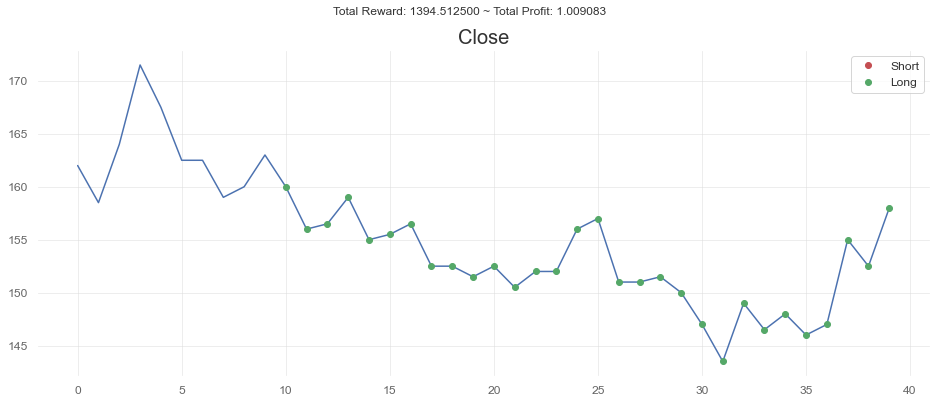

In [18]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


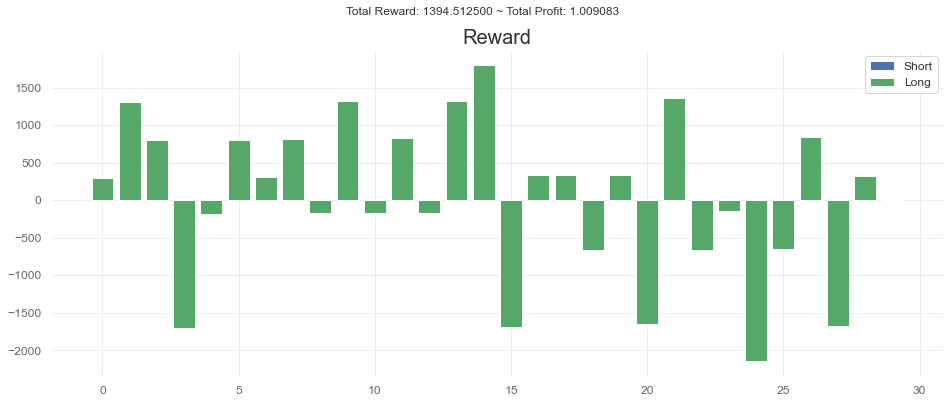

In [19]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


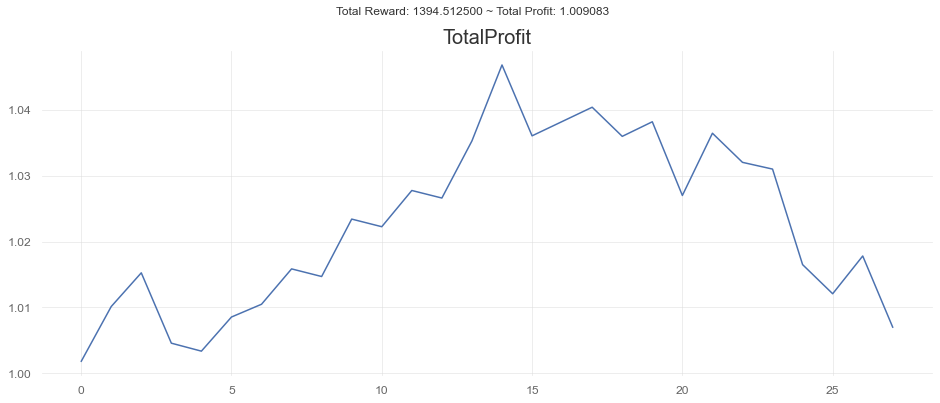

In [20]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)